# 전 세계 코로나 예측 & 동향 시각화

In [3]:
import random
import math
import xgboost as xgb
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import operator as op

### - 코로나 세계 동향 타임시리즈 데이터 불러오기

In [1]:
# 출처 : https://github.com/CSSEGISandData/COVID-19
import pandas as pd

cases_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
cases_df.to_csv('data/w_covid_time_series_cases.csv')

deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
deaths_df.to_csv('data/w_covid_time_series_deaths.csv')

recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
recoveries_df.to_csv('data/w_covid_time_series_recoveries.csv')

latest_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/05-12-2020.csv')
latest_df.to_csv('data/daily/w_covid_2020-05-12.csv')

In [2]:
display(cases_df.head(2))
display(deaths_df.head(2))
display(recoveries_df.head(2))
display(latest_df.head(2))

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,34194,34366,34451,34455,34740,34994,35070,35229,35301,35475
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,3278,3371,3454,3571,3667,3752,3851,3906,4008,4090


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,971,994,1010,1012,1048,1094,1113,1147,1164,1181
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,85,89,93,95,97,101,104,107,111,112


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,20882,21135,21216,21254,21454,22456,22824,23151,23273,23634
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,1875,1881,1946,2014,2062,2091,2137,2214,2264,2311


,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,2020-05-13 03:32:26,34.223334,-82.461707,34,0,0,34,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-05-13 03:32:26,30.295065,-92.414197,152,11,0,141,"Acadia, Louisiana, US"


In [4]:
cases_df[cases_df['Country/Region'] == 'Korea, South']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20
143,NaN,"Korea, South",35.907757,127.766922,1,1,2,2,3,4,...,13373,13417,13479,13512,13551,13612,13672,13711,13745,13771


In [4]:
cases = cases_df.iloc[:,4:]
deaths = deaths_df.iloc[:,4:]
recoveries = recoveries_df.iloc[:,4:]

In [5]:
display(cases.head(1))
display(deaths.head(1))
display(recoveries.head(1))

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20
0,0,0,0,0,0,0,0,0,0,0,...,15750,16509,17267,18054,18969,19551,20342,20917,21459,22142


,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20
0,0,0,0,0,0,0,0,0,0,0,...,265,270,294,300,309,327,357,369,384,405


,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20
0,0,0,0,0,0,0,0,0,0,0,...,1428,1450,1522,1585,1762,1830,1875,2171,2651,3013


- <font color = "#CC5D9D">대한민국의 영어 표기가 'Korea, South'라고 되어 있기에 쓰기 편하게 'Korea'로 변경<font>

In [6]:
korea = cases_df['Country/Region'] == "Korea, South"
korea.value_counts()

False    265
True       1
Name: Country/Region, dtype: int64

In [7]:
cases_df['Country/Region'] = cases_df['Country/Region'].replace('Korea, South','Korea')
deaths_df['Country/Region'] = deaths_df['Country/Region'].replace('Korea, South','Korea')
recoveries_df['Country/Region'] = recoveries_df['Country/Region'].replace('Korea, South','Korea')
korea = cases_df['Country/Region'] == "Korea"
korea.value_counts()

False    265
True       1
Name: Country/Region, dtype: int64

In [8]:
dates = cases.columns

total_cases = []
total_deaths = []
total_recovered = [] 
total_active = []
mortality_rate = []
recovery_rate = []

korea_cases = []; korea_deaths = []; korea_recovered = []
japan_cases = []; japan_deaths = []; japan_recovered = []
china_cases = []; china_deaths = []; china_recovered = []
italy_cases = []; italy_deaths = []; italy_recovered = []
usa_cases = []; usa_deaths = []; usa_recovered = []
spain_cases = []; spain_deaths = []; spain_recovered = []
france_cases = []; france_deaths = []; france_recovered = []
germany_cases = []; germany_deaths = []; germany_recovered = []
uk_cases = []; uk_deaths = []; uk_recovered = []
russia_cases = []; russia_deaths = []; russia_recovered = []
iran_cases = []; iran_deaths = []; iran_recovered = []

In [9]:
for k in dates:
    
    # 전세계 날짜별 누적 확진,사망,회복
    cases_sum = cases[k].sum()
    deaths_sum = deaths[k].sum()
    recovered_sum = recoveries[k].sum()
    
    # 전세계 날짜별 누적 확진,사망,회복의 합을 리스트형식으로 넣어줌
    total_cases.append(cases_sum)
    total_deaths.append(deaths_sum)
    total_recovered.append(recovered_sum)
    total_active.append(cases_sum - (deaths_sum+recovered_sum))
    
    # 전세계 날짜별 누계에 대한 사망률,회복률을 리스트형식으로 넣어줌
    mortality_rate.append(deaths_sum / cases_sum)
    recovery_rate.append(recovered_sum / cases_sum)
    
    # 각 나라별 & 날짜별 확진인원 누계
    korea_cases.append(cases_df[cases_df['Country/Region']=="Korea"][k].sum())
    japan_cases.append(cases_df[cases_df['Country/Region']=="Japan"][k].sum())
    china_cases.append(cases_df[cases_df['Country/Region']=='China'][k].sum())
    italy_cases.append(cases_df[cases_df['Country/Region']=='Italy'][k].sum())
    usa_cases.append(cases_df[cases_df['Country/Region']=='US'][k].sum())
    spain_cases.append(cases_df[cases_df['Country/Region']=='Spain'][k].sum())
    france_cases.append(cases_df[cases_df['Country/Region']=='France'][k].sum())
    germany_cases.append(cases_df[cases_df['Country/Region']=='Germany'][k].sum())
    uk_cases.append(cases_df[cases_df['Country/Region']=='United Kingdom'][k].sum())
    russia_cases.append(cases_df[cases_df['Country/Region']=='Russia'][k].sum())
    iran_cases.append(cases_df[cases_df['Country/Region']=='Iran'][k].sum())
    
    # 각 나라별 & 날짜별 사망인원 누계
    korea_deaths.append(deaths_df[deaths_df['Country/Region']=="Korea"][k].sum())
    japan_deaths.append(deaths_df[deaths_df['Country/Region']=="Japan"][k].sum())
    china_deaths.append(deaths_df[deaths_df['Country/Region']=='China'][k].sum())
    italy_deaths.append(deaths_df[deaths_df['Country/Region']=='Italy'][k].sum())
    usa_deaths.append(deaths_df[deaths_df['Country/Region']=='US'][k].sum())
    spain_deaths.append(deaths_df[deaths_df['Country/Region']=='Spain'][k].sum())
    france_deaths.append(deaths_df[deaths_df['Country/Region']=='France'][k].sum())
    germany_deaths.append(deaths_df[deaths_df['Country/Region']=='Germany'][k].sum())
    uk_deaths.append(deaths_df[deaths_df['Country/Region']=='United Kingdom'][k].sum())
    russia_deaths.append(deaths_df[deaths_df['Country/Region']=='Russia'][k].sum())
    iran_deaths.append(deaths_df[deaths_df['Country/Region']=='Iran'][k].sum())
    
    # 각 나라별 & 날짜별 회복인원 누계
    korea_recovered.append(recoveries_df[recoveries_df['Country/Region']=='Korea'][k].sum())
    japan_recovered.append(recoveries_df[recoveries_df['Country/Region']=='Japan'][k].sum())
    china_recovered.append(recoveries_df[recoveries_df['Country/Region']=='China'][k].sum())
    italy_recovered.append(recoveries_df[recoveries_df['Country/Region']=='Italy'][k].sum())
    usa_recovered.append(recoveries_df[recoveries_df['Country/Region']=='US'][k].sum())
    spain_recovered.append(recoveries_df[recoveries_df['Country/Region']=='Spain'][k].sum())
    france_recovered.append(recoveries_df[recoveries_df['Country/Region']=='France'][k].sum())
    germany_recovered.append(recoveries_df[recoveries_df['Country/Region']=='Germany'][k].sum())
    uk_recovered.append(recoveries_df[recoveries_df['Country/Region']=='United Kingdom'][k].sum())
    russia_recovered.append(recoveries_df[recoveries_df['Country/Region']=='Russia'][k].sum())
    iran_recovered.append(recoveries_df[recoveries_df['Country/Region']=='Iran'][k].sum())

In [10]:
# 전세계 하루 증가량을 구하여 날짜별 리스트형식으로 넣어주는 함수
def daily_increase(data):
    daily = [] 
    for k in range(len(data)):
        if k == 0:
            daily.append(data[0])
        else:
            daily.append(data[k]-data[k-1])
    return daily

In [11]:
# 전세계 & 나라별 하루 확진판정인원
world_daily_increase = daily_increase(total_cases)
korea_daily_increase = daily_increase(korea_cases)
japan_daily_increase = daily_increase(japan_cases)
china_daily_increase = daily_increase(china_cases)
italy_daily_increase = daily_increase(italy_cases)
usa_daily_increase = daily_increase(usa_cases)
spain_daily_increase = daily_increase(spain_cases)
france_daily_increase = daily_increase(france_cases)
germany_daily_increase = daily_increase(germany_cases)
uk_daily_increase = daily_increase(uk_cases)
russia_daily_increase = daily_increase(russia_cases)
iran_daily_increase = daily_increase(iran_cases)

# 전세계 & 나라별 하루 사망인원
world_daily_deaths = daily_increase(total_deaths)
korea_daily_deaths = daily_increase(korea_deaths)
japan_daily_deaths = daily_increase(japan_deaths)
china_daily_deaths = daily_increase(china_deaths)
italy_daily_deaths = daily_increase(italy_deaths)
usa_daily_deaths = daily_increase(usa_deaths)
spain_daily_deaths = daily_increase(spain_deaths)
france_daily_deaths = daily_increase(france_deaths)
germany_daily_deaths = daily_increase(germany_deaths)
uk_daily_deaths = daily_increase(uk_deaths)
russia_daily_deaths = daily_increase(russia_deaths)
iran_daily_deaths = daily_increase(iran_deaths)

# 전세계 & 나라별 하루 회복인원
world_daily_recovery = daily_increase(total_recovered)
korea_daily_recovery = daily_increase(korea_recovered)
japan_daily_recovery = daily_increase(japan_recovered)
china_daily_recovery = daily_increase(china_recovered)
italy_daily_recovery = daily_increase(italy_recovered)
usa_daily_recovery = daily_increase(usa_recovered)
spain_daily_recovery = daily_increase(spain_recovered)
france_daily_recovery = daily_increase(france_recovered)
germany_daily_recovery = daily_increase(germany_recovered)
uk_daily_recovery = daily_increase(uk_recovered)
russia_daily_recovery = daily_increase(russia_recovered)
iran_daily_recovery = daily_increase(iran_recovered)

In [12]:
import numpy as np

first_estimate_day = np.array([k for k in range(len(dates))])[:,np.newaxis]
#first_estimate_day

total_cases = np.array(total_cases)[:,np.newaxis]
#total_cases

total_deaths = np.array(total_deaths)[:,np.newaxis]
#total_deaths

total_recovered = np.array(total_recovered)[:,np.newaxis]
#total_recovered

In [13]:
# 기록상의 시작점 20년 1월 22일 부터 기록상의 현재 보다 10일 앞선 날까지의 날짜를
# 만들기 위해 array 리스트 형식으로 만듬
prospect_predict_num = np.array([k for k in range(len(dates)+10)])[:,np.newaxis]  # 현재까지 기록된 날짜 + 10
previous_num = prospect_predict_num[:-10]

In [14]:
import datetime as dt

start = '1.22'
st_dt = dt.datetime.strptime(start, '%m.%d')
#st_dt

prospect_predict_dt = []  # # 현재까지 기록된 날짜 + 10을 날짜형태로 변형
for k in range(len(prospect_predict_num)):
    prospect_predict_dt.append((st_dt + dt.timedelta(days=k)).strftime('%m.%d'))

- <font color = "#CC5D9D">예측데이터 확정<font>

In [15]:
X_train_cases = first_estimate_day  # 1/22일 부터 현재까지 날짜의 숫자리스트 형식
y_train_cases = total_cases  # 1/22일 부터 현재까지 누적 확진판정 수

In [16]:
X_train_deaths = first_estimate_day  # 1/22일 부터 현재까지 날짜의 숫자리스트 형식
y_train_deaths = total_deaths  # 1/22일 부터 현재까지 누적 사망판정 수

In [17]:
X_train_recovered = first_estimate_day  # 1/22일 부터 현재까지 날짜의 숫자리스트 형식
y_train_recovered = total_recovered  # 1/22일 부터 현재까지 누적 회복판정 수

In [18]:
# SVR의 최적의 파라미터(매개변수)를 찾아내기 위한 설정
from sklearn.model_selection import RandomizedSearchCV
#c = [0.01, 0.1, 1]
#gamma = [0.01, 0.1, 1]
#epsilon = [0.01, 0.1, 1]
#shrinking = [True, False]
#degree = [3, 4, 5]

#svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

#svm = SVR(kernel='poly')
#svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
#svm_search.fit(X_train_cases, y_train_cases)
#svm_search.best_params_

- <font color = "#CC5D9D">SVR : 향후 이벤트의 시계열 예측<font>

In [19]:
from sklearn.svm import SVR

svm_fixed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=4, C=0.1)
svm_fixed.fit(X_train_cases, y_train_cases)
svm_pred_cases = svm_fixed.predict(prospect_predict_num)  # 1/22일 부터 현재까지의 누적 확진판정 데이터를 학습한 결과로 10일 이후를 예측

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
from sklearn.svm import SVR

svm_fixed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=4, C=0.1)
svm_fixed.fit(X_train_deaths, y_train_deaths)
svm_pred_deaths = svm_fixed.predict(prospect_predict_num)  # 1/22일 부터 현재까지의 누적 사망판정 데이터를 학습한 결과로 10일 이후를 예측

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
from sklearn.svm import SVR

svm_fixed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=4, C=0.1)
svm_fixed.fit(X_train_recovered, y_train_recovered)
svm_pred_recovered = svm_fixed.predict(prospect_predict_num)  # 1/22일 부터 현재까지의 누적 회복판정 데이터를 학습한 결과로 10일 이후를 예측

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


- <font color = "#CC5D9D">그래프 모듈 불러오기<font>

In [22]:
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
plt.style.use('fivethirtyeight')
%matplotlib inline

- <font color = "#CC5D9D">SVR을 이용한 예측 테스트(1/12일 부터 현재+10일까지를 현재까지 현황을 학습한 결과를 통해 예측)<font>

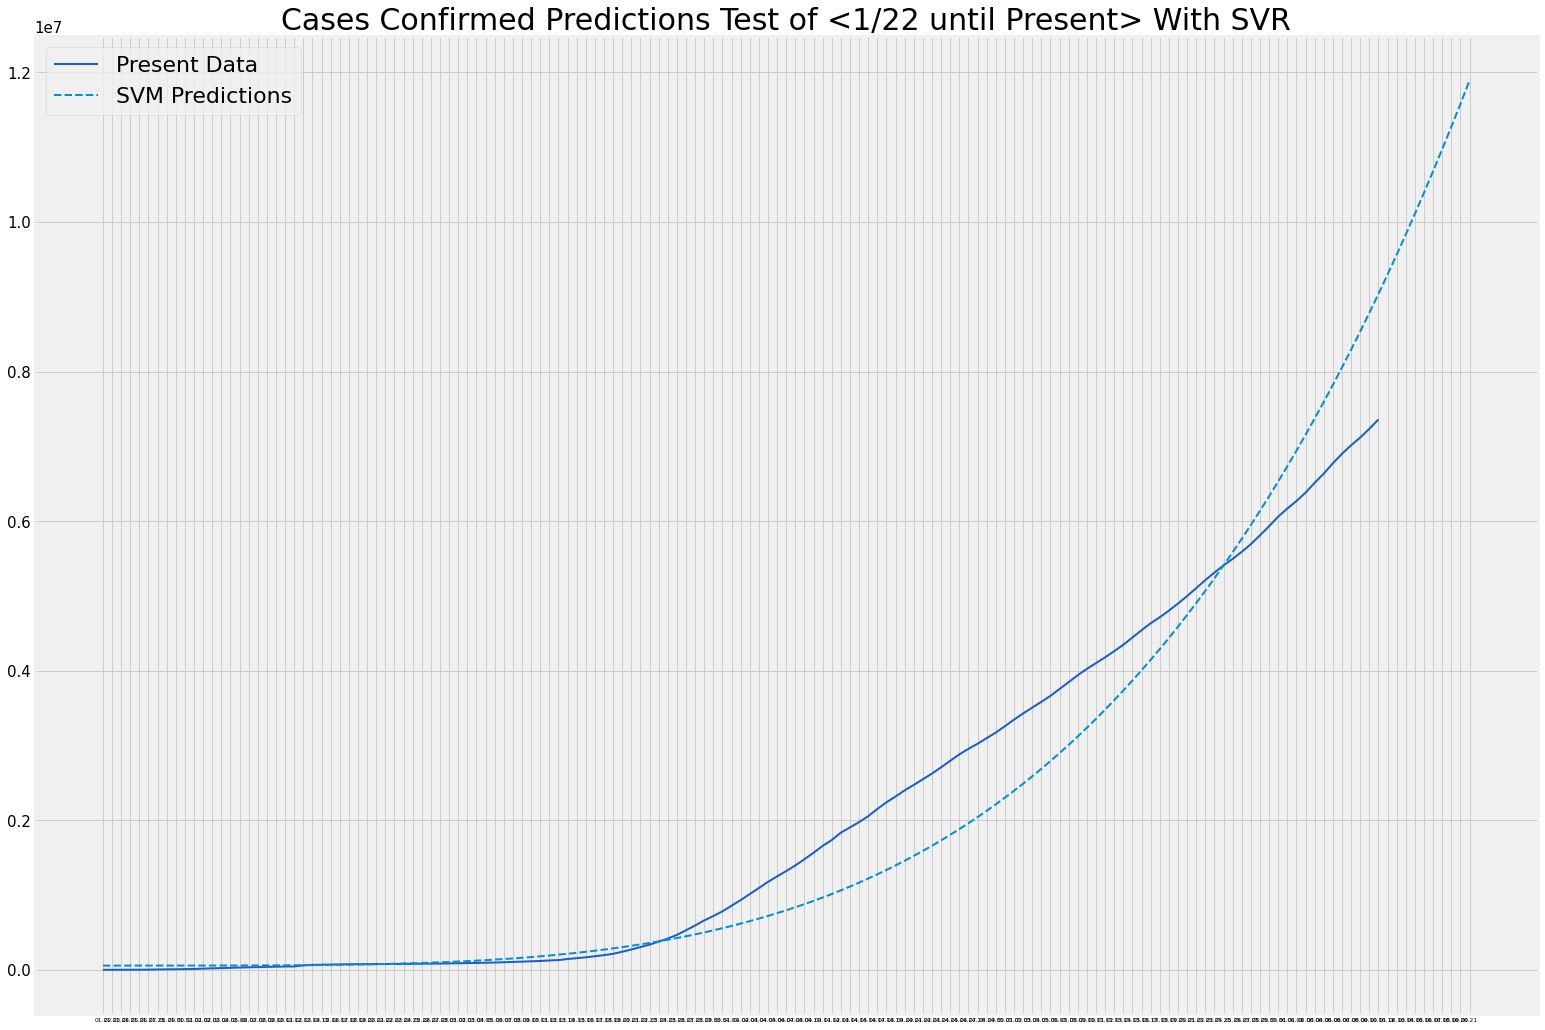

In [23]:
plt.rc('xtick', labelsize=6)  # x 라벨 사이즈
plt.rc('ytick', labelsize=15)  # y 라벨 사이즈
plt.rcParams.update({'font.size': 22})  # 왼쪽 상단위 툴팁 폰트 사이즈
plt.rcParams['figure.figsize'] = [24, 18]  # 그래프 전체 사이즈

# 1/22일 부터 현재까지의 누적 확진판정
plt.plot(total_cases, linewidth=2, color='#1a5ec9')
# 첫 추정일로부터 현재까지의 누적 확진판정 + 10일뒤를 예측한 결괏값
plt.plot(prospect_predict_dt,svm_pred_cases, linestyle='--', linewidth=2)
# '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'

plt.title('Cases Confirmed Predictions Test of <1/22 until Present> With SVR', {'fontsize':30})

plt.legend(['Present Data', 'SVM Predictions'])

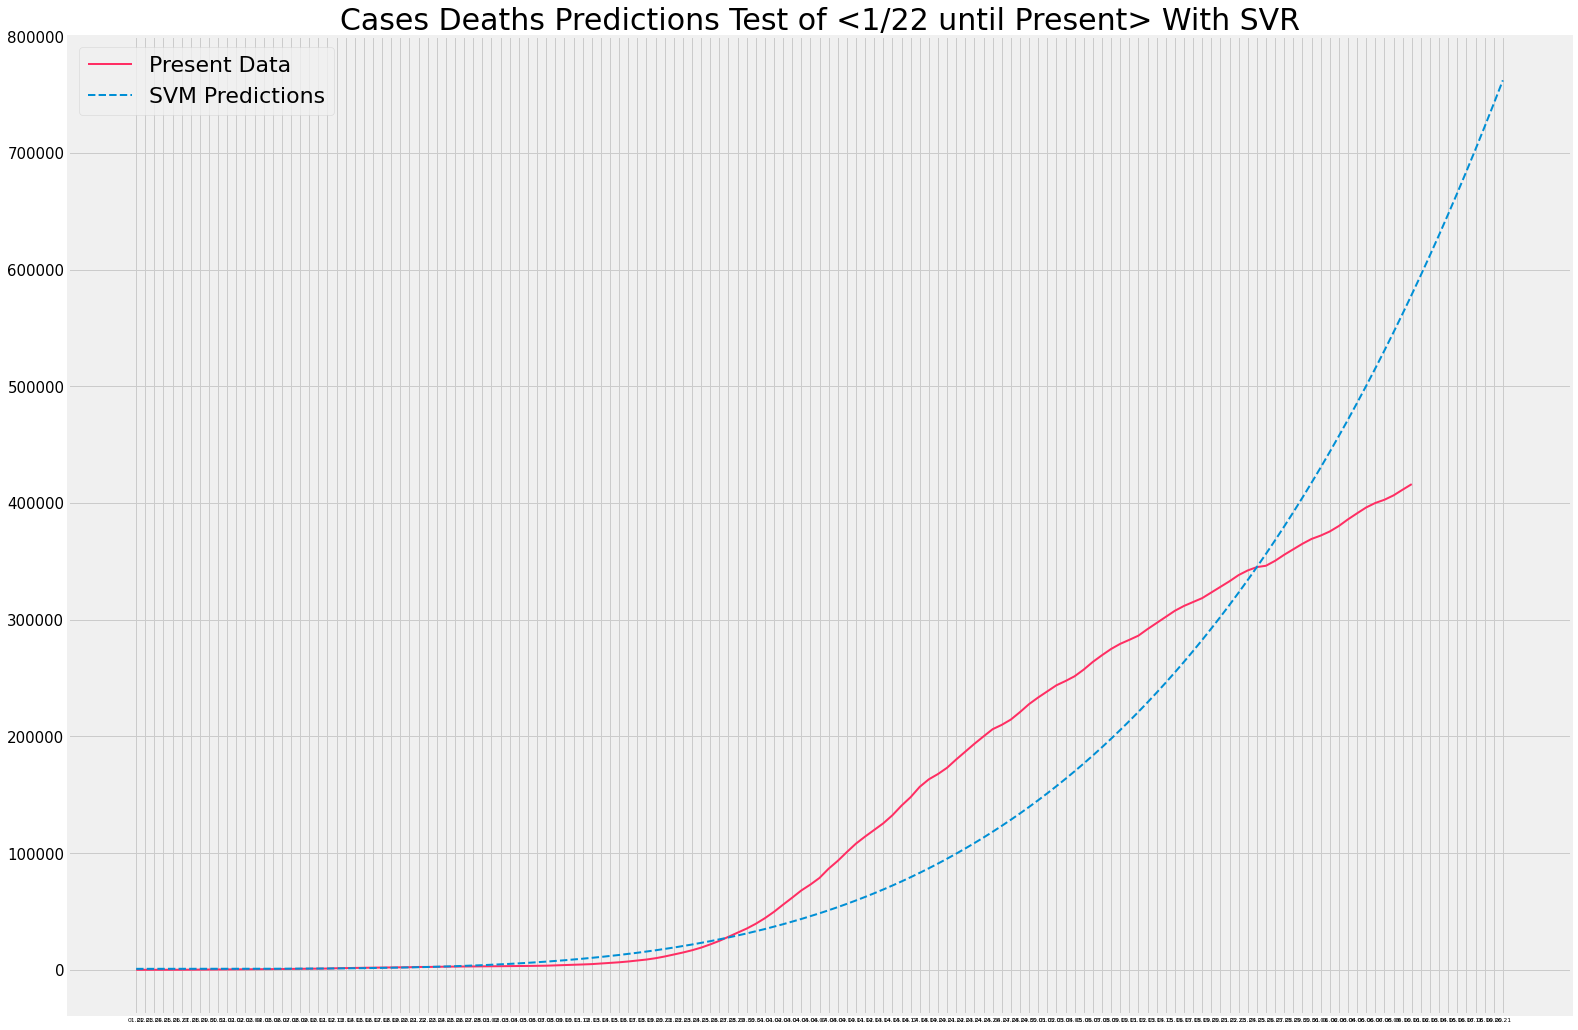

In [24]:
plt.rc('xtick', labelsize=6)  # x 라벨 사이즈
plt.rc('ytick', labelsize=15)  # y 라벨 사이즈
plt.rcParams.update({'font.size': 22})  # 왼쪽 상단위 툴팁 폰트 사이즈
plt.rcParams['figure.figsize'] = [24, 18]  # 그래프 전체 사이즈

# 1/22일 부터 현재까지의 누적 확진판정
plt.plot(total_deaths, linewidth=2, color='#ff2e63')
# 첫 추정일로부터 현재까지의 누적 확진판정 + 10일뒤를 예측한 결괏값
plt.plot(prospect_predict_dt,svm_pred_deaths, linestyle='--', linewidth=2)
# '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'

plt.title('Cases Deaths Predictions Test of <1/22 until Present> With SVR', {'fontsize':30})

plt.legend(['Present Data', 'SVM Predictions'])

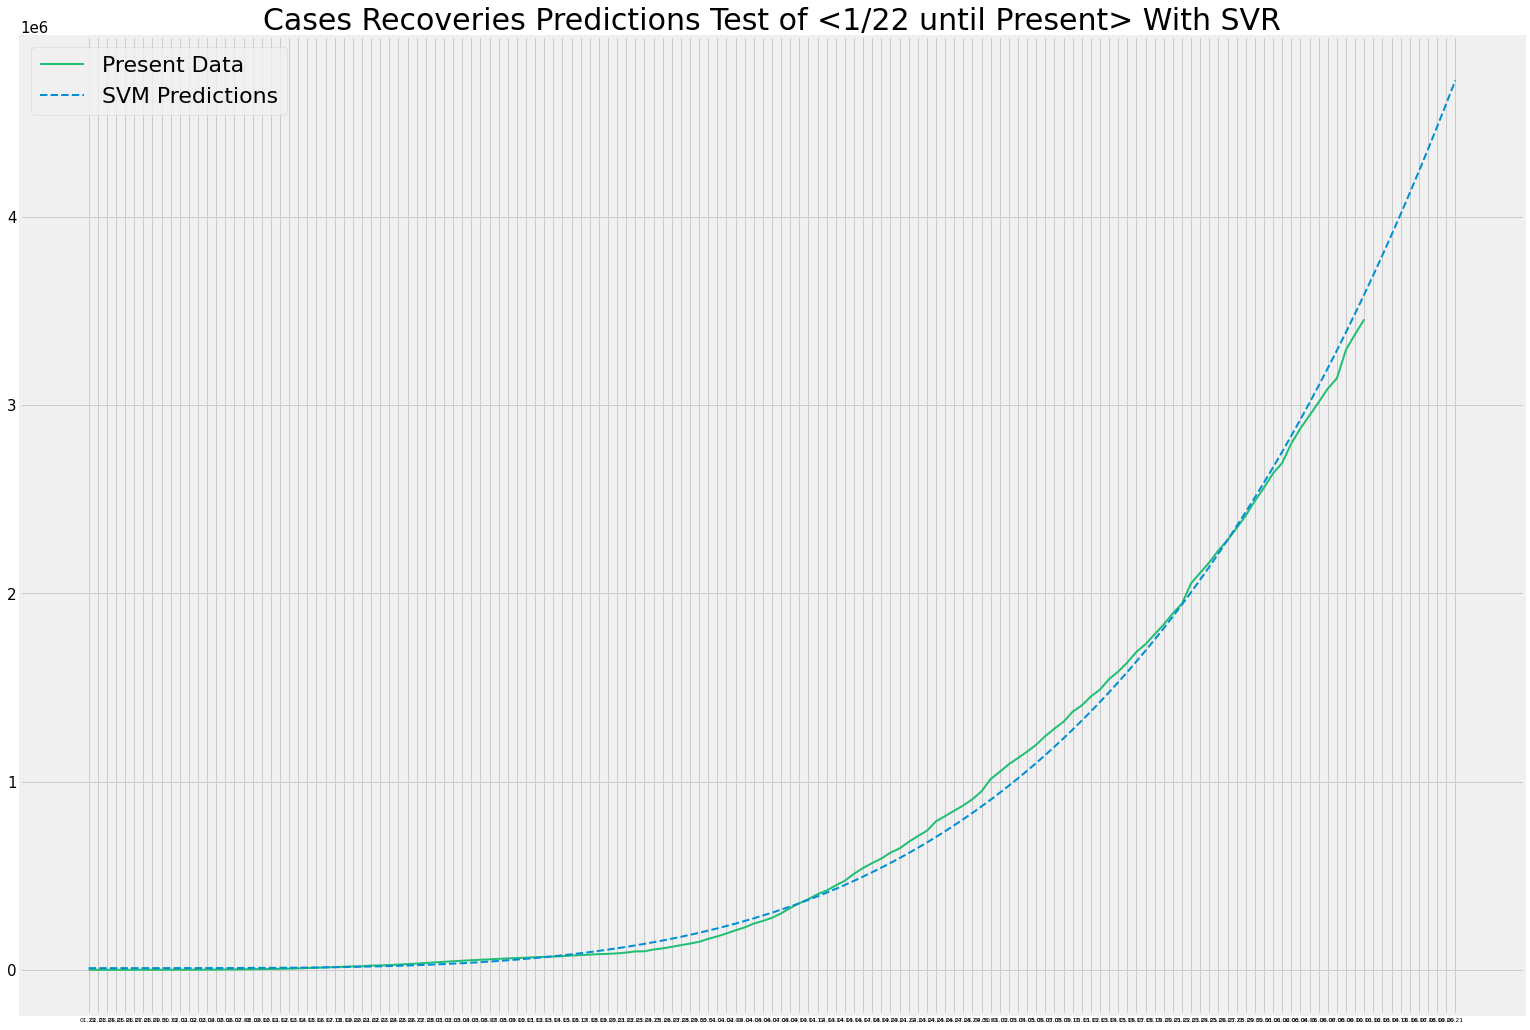

In [25]:
plt.rc('xtick', labelsize=6)  # x 라벨 사이즈
plt.rc('ytick', labelsize=15)  # y 라벨 사이즈
plt.rcParams.update({'font.size': 22})  # 왼쪽 상단위 툴팁 폰트 사이즈
plt.rcParams['figure.figsize'] = [24, 18]  # 그래프 전체 사이즈

# 1/22일 부터 현재까지의 누적 확진판정
plt.plot(total_recovered, linewidth=2, color='#21bf73')
# 첫 추정일로부터 현재까지의 누적 확진판정 + 10일뒤를 예측한 결괏값
plt.plot(prospect_predict_dt,svm_pred_recovered, linestyle='--', linewidth=2)
# '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'

plt.title('Cases Recoveries Predictions Test of <1/22 until Present> With SVR', {'fontsize':30})

plt.legend(['Present Data', 'SVM Predictions'])

- <font color = "#CC5D9D">ploynomialFeatures : 다항변환<font>

In [26]:
from sklearn.preprocessing import PolynomialFeatures

# LinearRegression에 적용할 다항변환 데이터
poly = PolynomialFeatures(degree=3)  # 차수 : 3차
poly_X_train_cases = poly.fit_transform(X_train_cases)
poly_prospect_predict_cases = poly.fit_transform(prospect_predict_num)
# ------------------------------------------
# bayesian에 적용할 다항변환 데이터
bayesian_poly = PolynomialFeatures(degree=4)
bay_poly_X_train_cases = bayesian_poly.fit_transform(X_train_cases)
bay_poly_prospect_predict_cases = bayesian_poly.fit_transform(prospect_predict_num)

In [27]:
from sklearn.preprocessing import PolynomialFeatures

# LinearRegression에 적용할 다항변환 데이터
poly = PolynomialFeatures(degree=3)  # 차수 : 3차
poly_X_train_deaths = poly.fit_transform(X_train_deaths)
poly_prospect_predict_deaths = poly.fit_transform(prospect_predict_num)
# ------------------------------------------
# bayesian에 적용할 다항변환 데이터
bayesian_poly = PolynomialFeatures(degree=4)
bay_poly_X_train_deaths = bayesian_poly.fit_transform(X_train_deaths)
bay_poly_prospect_predict_deaths = bayesian_poly.fit_transform(prospect_predict_num)

In [28]:
from sklearn.preprocessing import PolynomialFeatures

# LinearRegression에 적용할 다항변환 데이터
poly = PolynomialFeatures(degree=3)  # 차수 : 3차
poly_X_train_recovered = poly.fit_transform(X_train_recovered)
poly_prospect_predict_recovered = poly.fit_transform(prospect_predict_num)
# ------------------------------------------
# bayesian에 적용할 다항변환 데이터
bayesian_poly = PolynomialFeatures(degree=4)
bay_poly_X_train_recovered = bayesian_poly.fit_transform(X_train_recovered)
bay_poly_prospect_predict_recovered = bayesian_poly.fit_transform(prospect_predict_num)

- <font color = "#CC5D9D">LinearRegression : 선형 회귀<font>

In [29]:
from sklearn.linear_model import LinearRegression

liR = LinearRegression(normalize=True, fit_intercept=False)
liR.fit(poly_X_train_cases, y_train_cases)
linear_pred_cases = liR.predict(poly_prospect_predict_cases)

In [30]:
from sklearn.linear_model import LinearRegression

liR = LinearRegression(normalize=True, fit_intercept=False)
liR.fit(poly_X_train_deaths, y_train_deaths)
linear_pred_deaths = liR.predict(poly_prospect_predict_deaths)

In [31]:
from sklearn.linear_model import LinearRegression

liR = LinearRegression(normalize=True, fit_intercept=False)
liR.fit(poly_X_train_recovered, y_train_recovered)
linear_pred_recovered = liR.predict(poly_prospect_predict_recovered)

In [32]:
print(liR.coef_)  # 추정된 가중치 벡터

[[-2.11906817e+03  2.26800903e+03 -1.26365157e+02  2.04176359e+00]]


- <font color = "#CC5D9D">LinearRegression을 이용한 예측 테스트(1/12일 부터 현재+10일까지를 현재까지 현황을 학습한 결과를 통해 예측)<font>

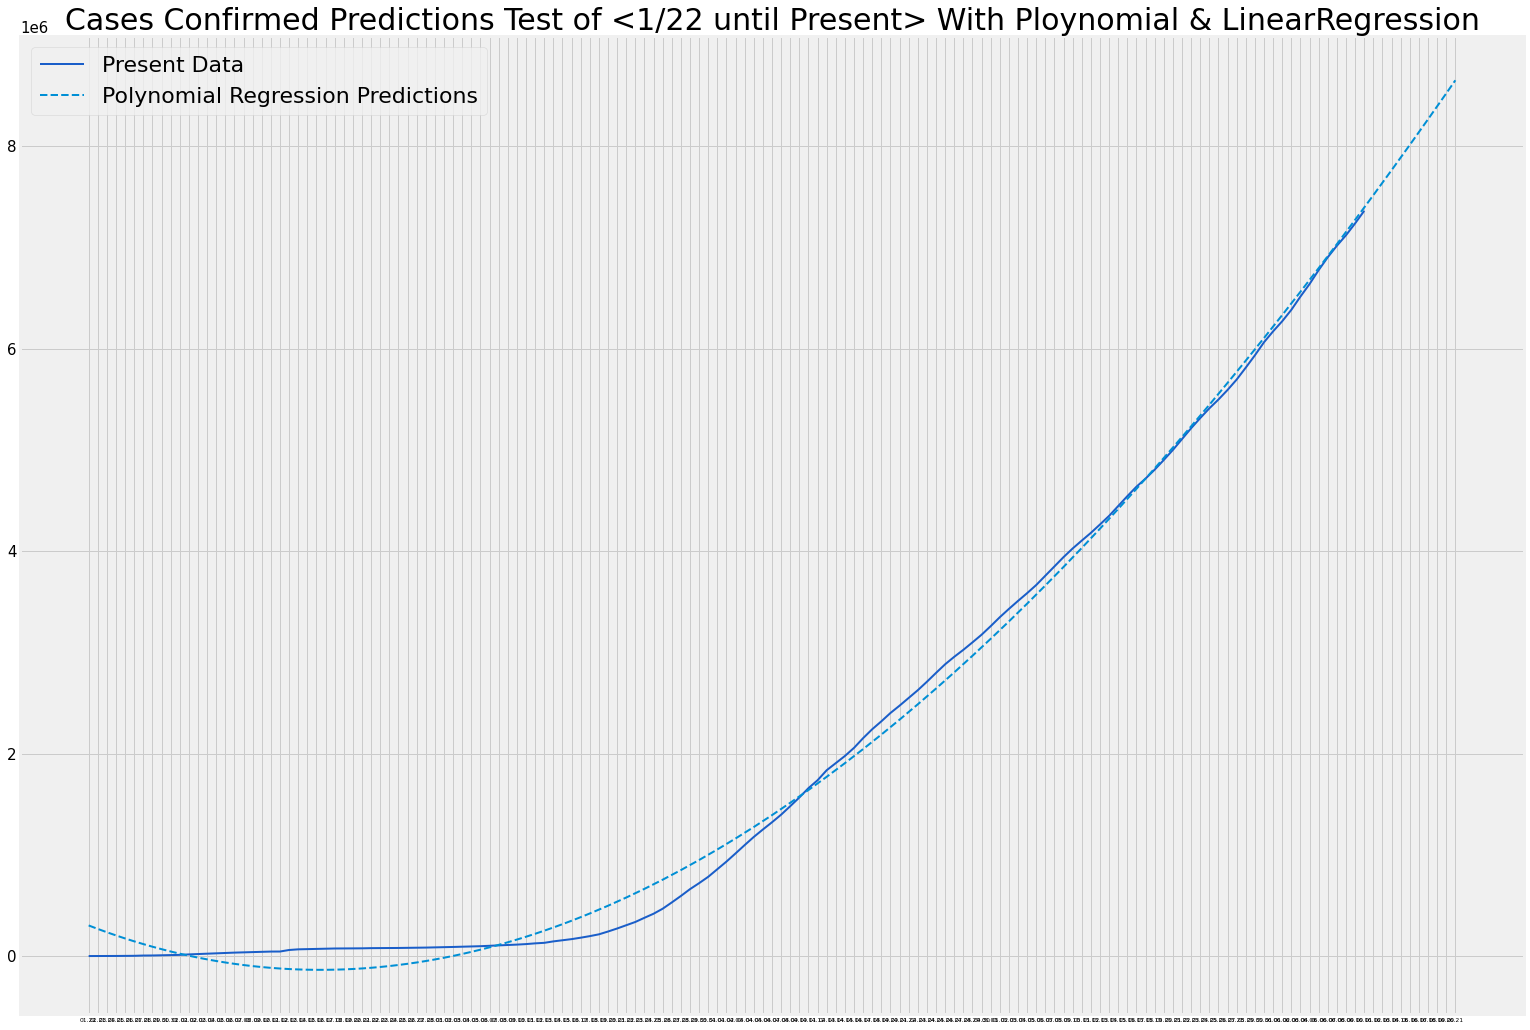

In [33]:
# 그래프 전체사이즈, x & y라벨 폰트사이즈, 툴팁 폰트사이즈는 상속받음
plt.plot(total_cases, linewidth=2, color='#1a5ec9')
plt.plot(prospect_predict_dt,linear_pred_cases, linestyle='--', linewidth=2)

plt.title('Cases Confirmed Predictions Test of <1/22 until Present> With Ploynomial & LinearRegression', {'fontsize':30})

plt.legend(['Present Data', 'Polynomial Regression Predictions'])

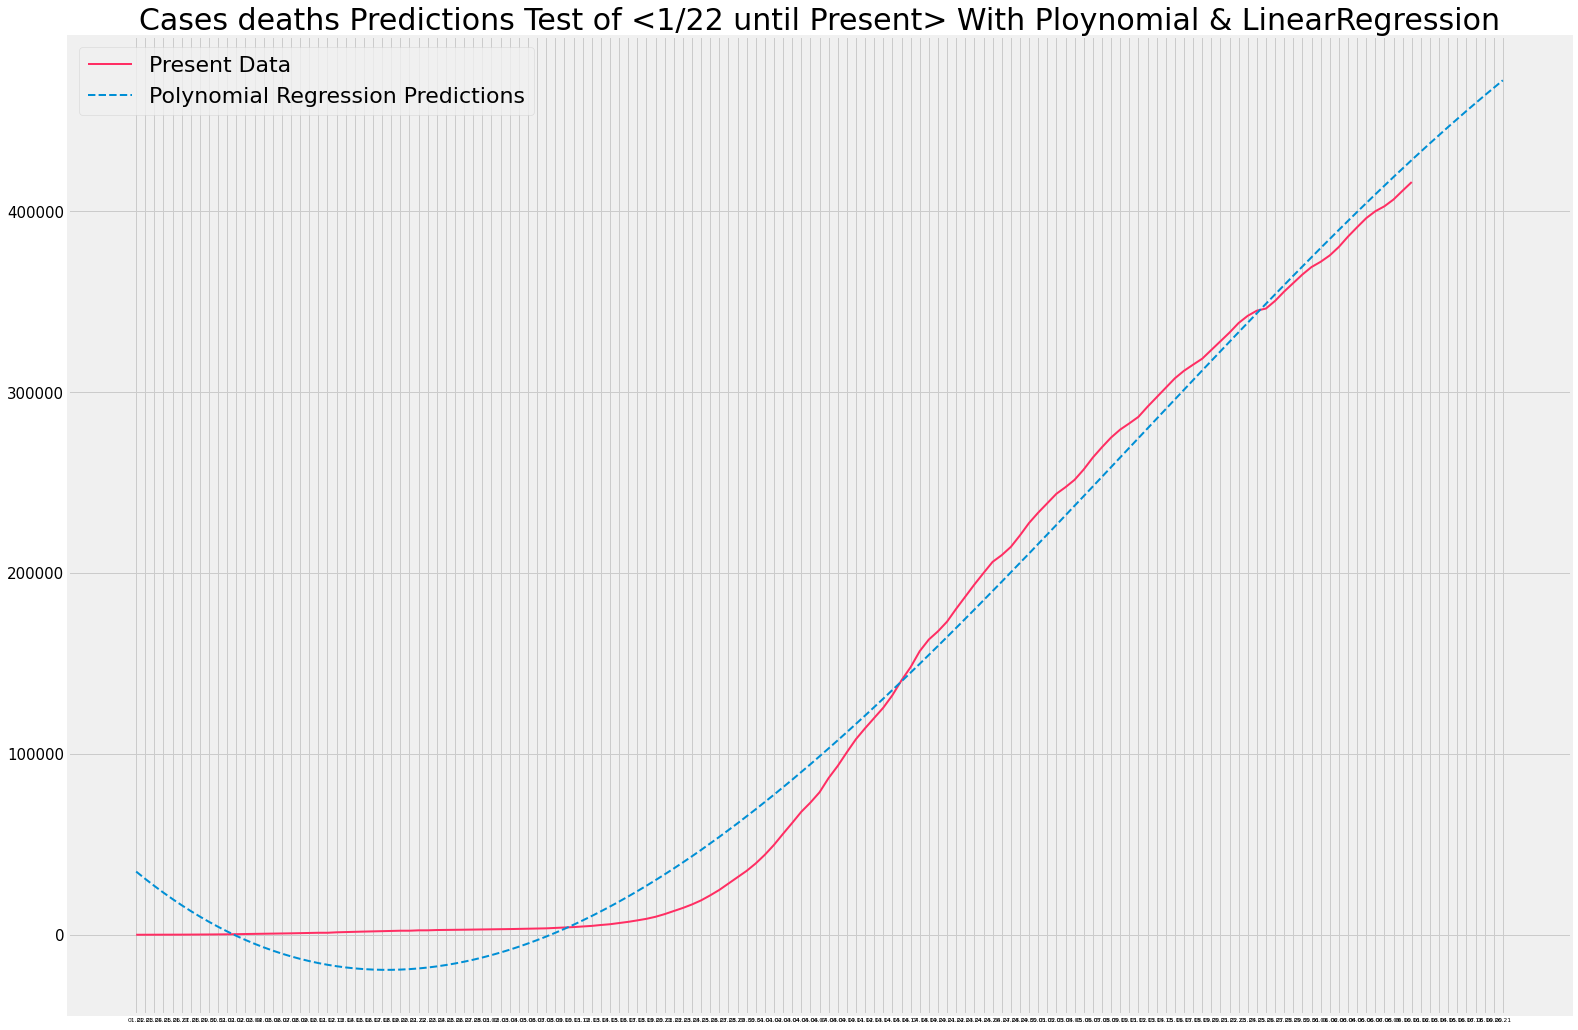

In [34]:
# 그래프 전체사이즈, x & y라벨 폰트사이즈, 툴팁 폰트사이즈는 상속받음
plt.plot(total_deaths, linewidth=2, color='#ff2e63')
plt.plot(prospect_predict_dt,linear_pred_deaths, linestyle='--', linewidth=2)

plt.title('Cases deaths Predictions Test of <1/22 until Present> With Ploynomial & LinearRegression', {'fontsize':30})

plt.legend(['Present Data', 'Polynomial Regression Predictions'])

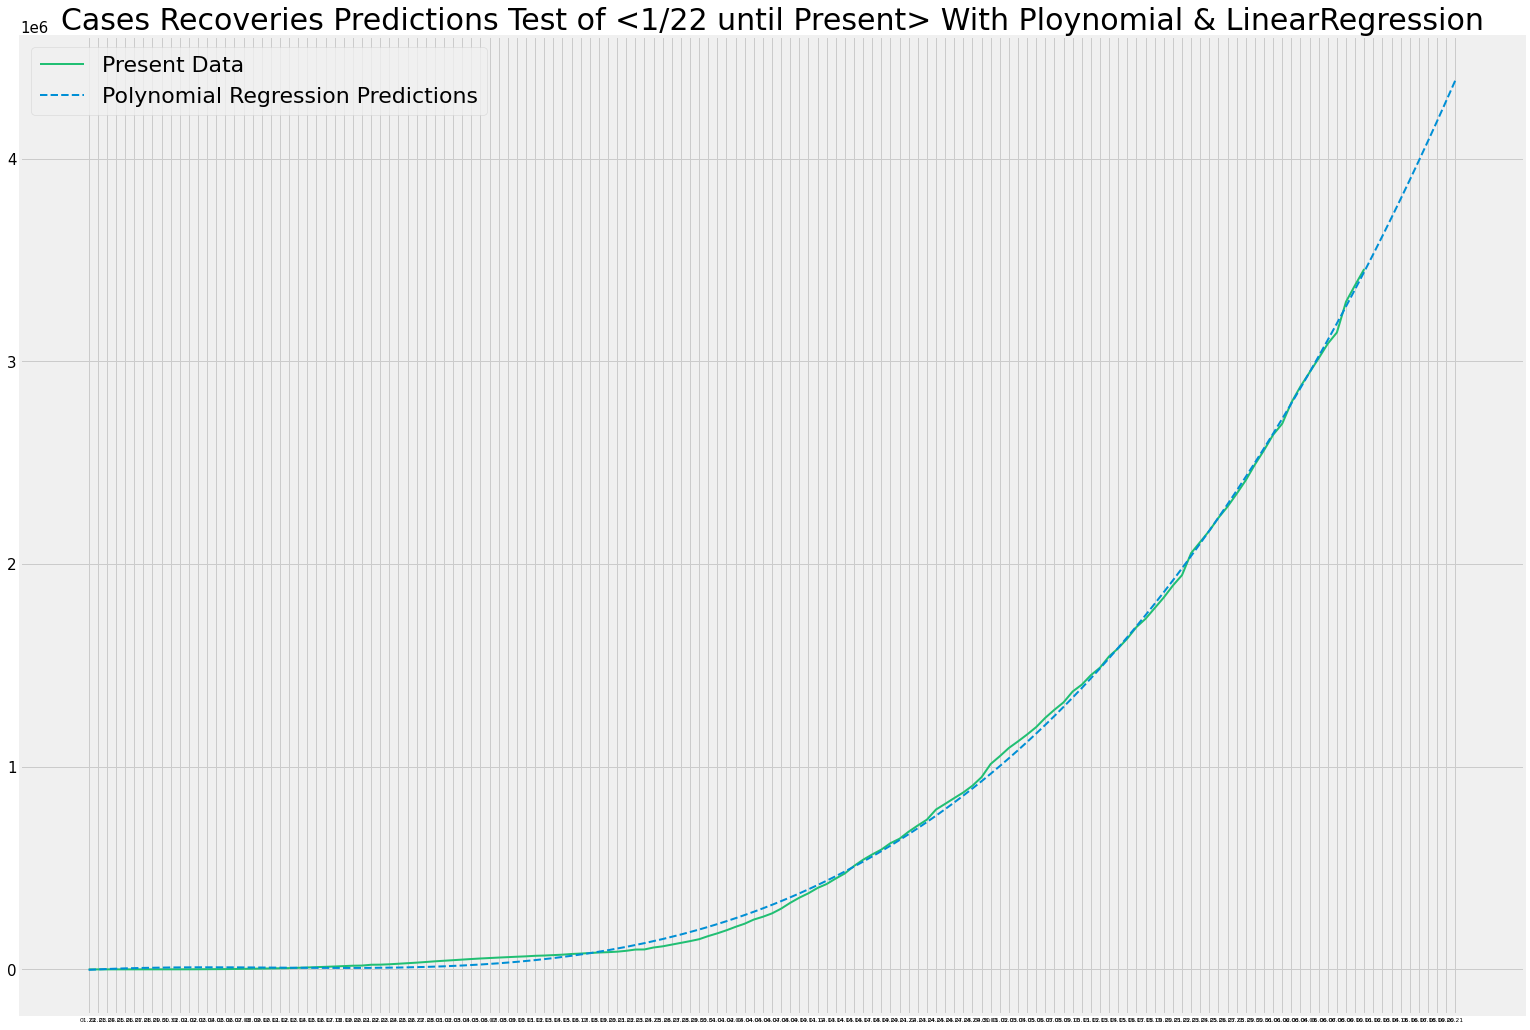

In [35]:
# 그래프 전체사이즈, x & y라벨 폰트사이즈, 툴팁 폰트사이즈는 상속받음
plt.plot(total_recovered, linewidth=2, color='#21bf73')
plt.plot(prospect_predict_dt,linear_pred_recovered, linestyle='--', linewidth=2)

plt.title('Cases Recoveries Predictions Test of <1/22 until Present> With Ploynomial & LinearRegression', {'fontsize':30})

plt.legend(['Present Data','Polynomial Regression Predictions'])

- <font color = "#CC5D9D">BayesianRidge : 능선 회귀<font>

In [36]:
from sklearn.linear_model import BayesianRidge

tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bay_poly_X_train_cases, y_train_cases)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.1s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                  

In [37]:
display(bayesian_search.best_params_)  # 최적의 매개변수
display(bayesian_search.best_estimator_)  # 최적의 추정량

{'tol': 0.01,
 'normalize': True,
 'lambda_2': 1e-07,
 'lambda_1': 0.0001,
 'alpha_2': 0.001,
 'alpha_1': 1e-06}

BayesianRidge(alpha_1=1e-06, alpha_2=0.001, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=False,
              lambda_1=0.0001, lambda_2=1e-07, lambda_init=None, n_iter=300,
              normalize=True, tol=0.01, verbose=False)

In [38]:
bayesian_fixed = bayesian_search.best_estimator_
bayesian_fixed.fit(bay_poly_X_train_cases, y_train_cases)  # 최적의 추정량에 재학습
bayesian_pred_cases = bayesian_fixed.predict(bay_poly_prospect_predict_cases)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [39]:
bayesian_fixed = bayesian_search.best_estimator_
bayesian_fixed.fit(bay_poly_X_train_deaths, y_train_deaths)  # 최적의 추정량에 재학습
bayesian_pred_deaths = bayesian_fixed.predict(bay_poly_prospect_predict_deaths)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [40]:
bayesian_fixed = bayesian_search.best_estimator_
bayesian_fixed.fit(bay_poly_X_train_recovered, y_train_recovered)  # 최적의 추정량에 재학습
bayesian_pred_recovered = bayesian_fixed.predict(bay_poly_prospect_predict_recovered)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


- <font color = "#CC5D9D">BayesianRidge을 이용한 예측 테스트(1/12일 부터 현재+10일까지를 현재까지 현황을 학습한 결과를 통해 예측)<font>

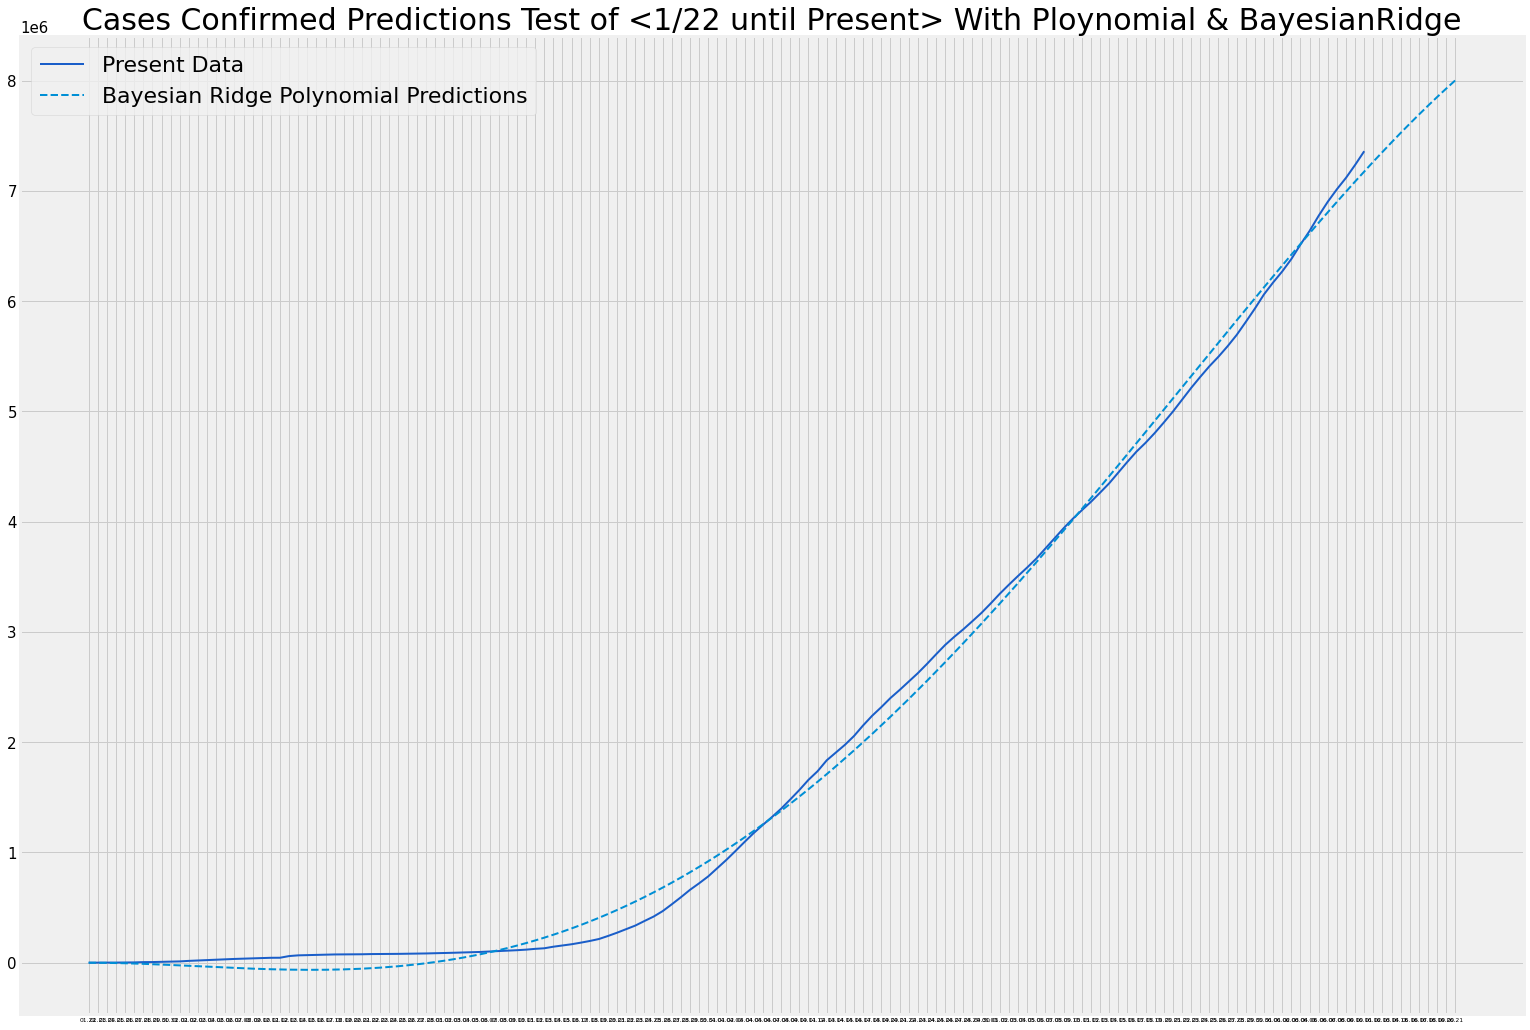

In [41]:
plt.plot(total_cases, linewidth=2, color='#1a5ec9')
plt.plot(prospect_predict_dt, bayesian_pred_cases, linestyle='--', linewidth=2)

plt.title('Cases Confirmed Predictions Test of <1/22 until Present> With Ploynomial & BayesianRidge', {'fontsize':30})

plt.legend(['Present Data', 'Bayesian Ridge Polynomial Predictions'])

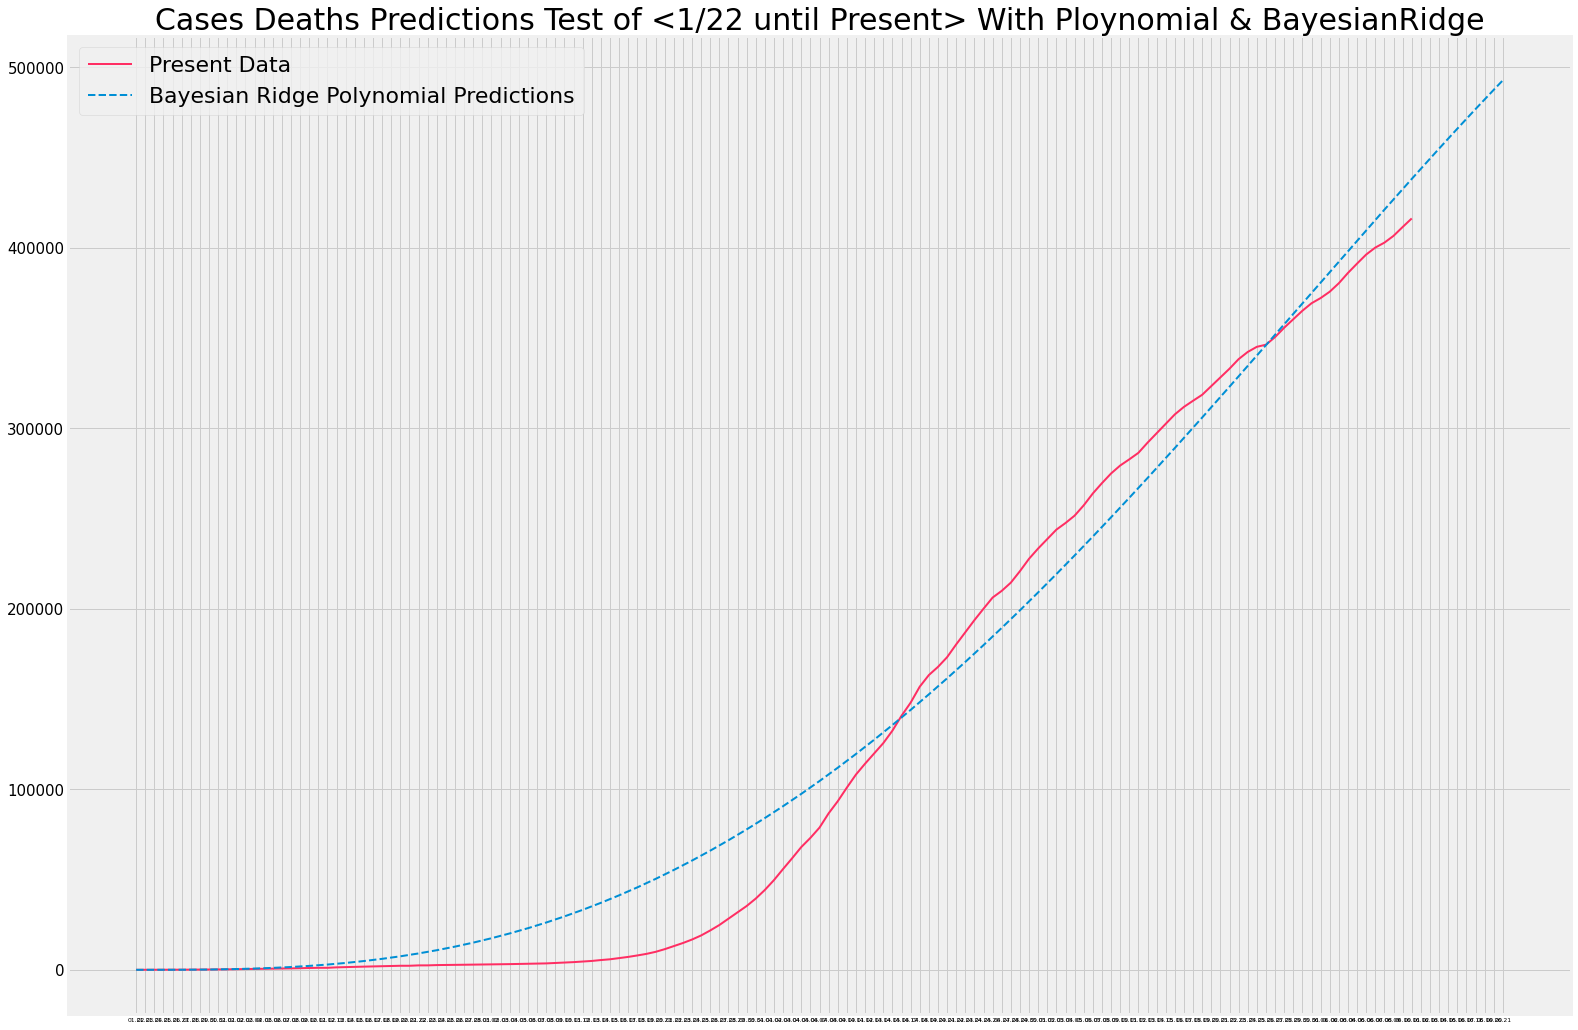

In [42]:
plt.plot(total_deaths, linewidth=2, color='#ff2e63')
plt.plot(prospect_predict_dt, bayesian_pred_deaths, linestyle='--', linewidth=2)

plt.title('Cases Deaths Predictions Test of <1/22 until Present> With Ploynomial & BayesianRidge', {'fontsize':30})

plt.legend(['Present Data', 'Bayesian Ridge Polynomial Predictions'])

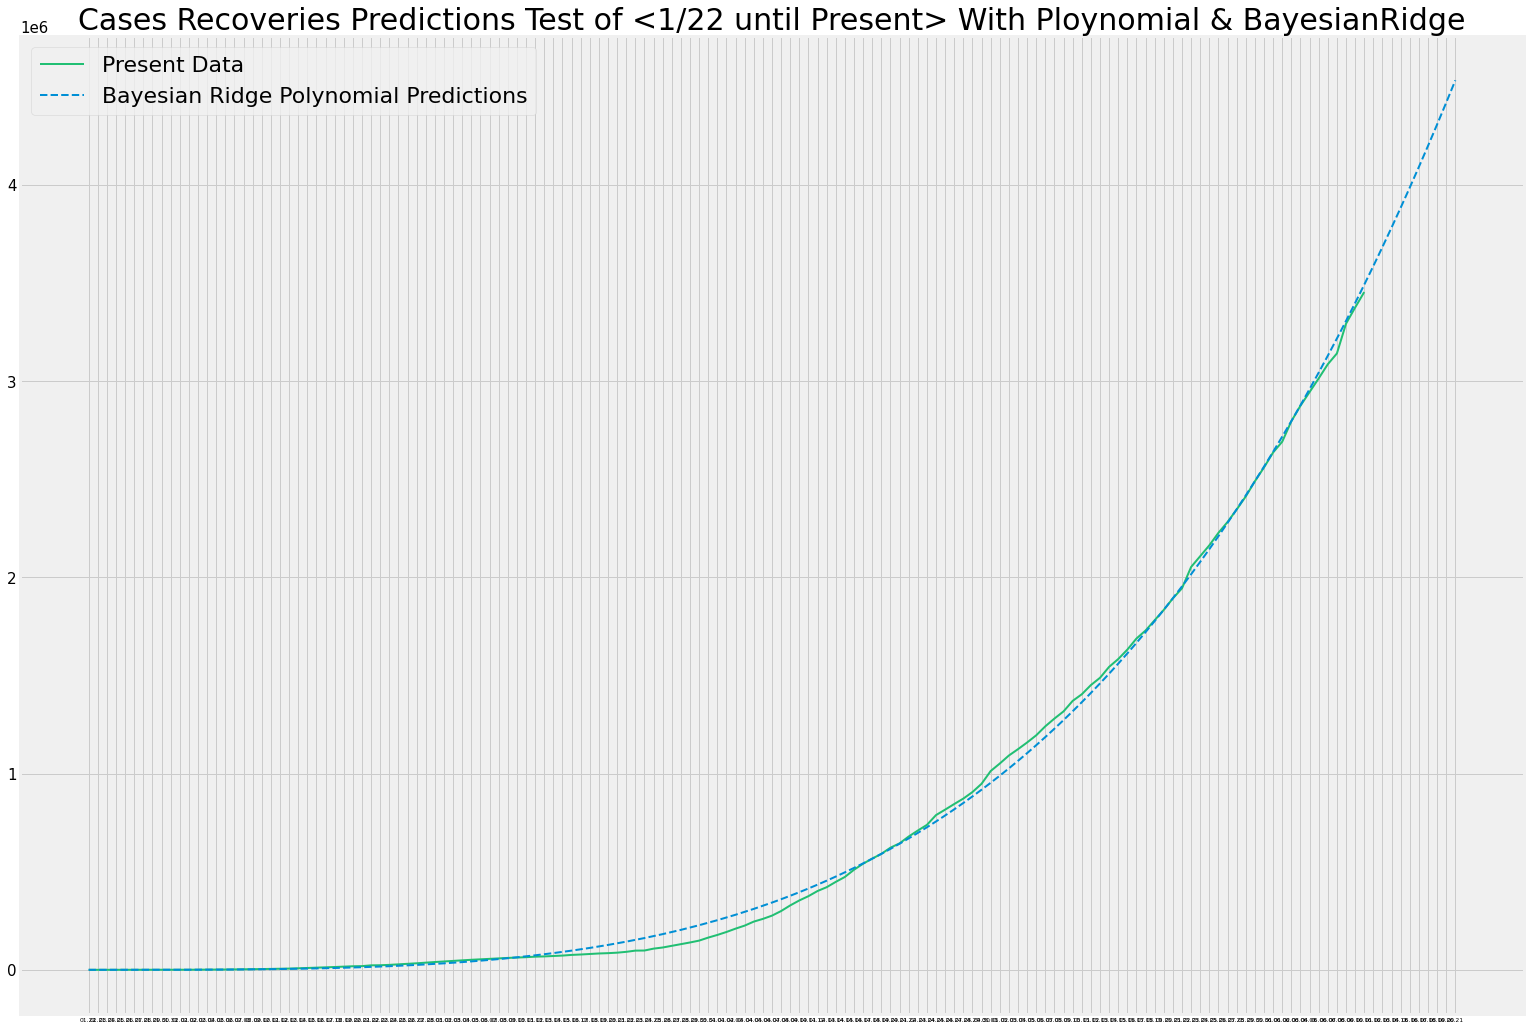

In [43]:
plt.plot(total_recovered, linewidth=2, color='#21bf73')
plt.plot(prospect_predict_dt, bayesian_pred_recovered, linestyle='--', linewidth=2)

plt.title('Cases Recoveries Predictions Test of <1/22 until Present> With Ploynomial & BayesianRidge', {'fontsize':30})

plt.legend(['Present Data', 'Bayesian Ridge Polynomial Predictions'])

In [44]:
previous_num = previous_num.reshape(1, -1)[0]
previous_num

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140])

- <font color = "#CC5D9D">전세계 날짜의 흐름에 따른 누적 확진판정 수<font>

In [45]:
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import calmap
import folium

# color pallette
cnf, dth, rec, act = '#393e46', '#ff2e63', '#21bf73', '#fe9801' 

# converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   

# hide warnings
import warnings
warnings.filterwarnings('ignore')

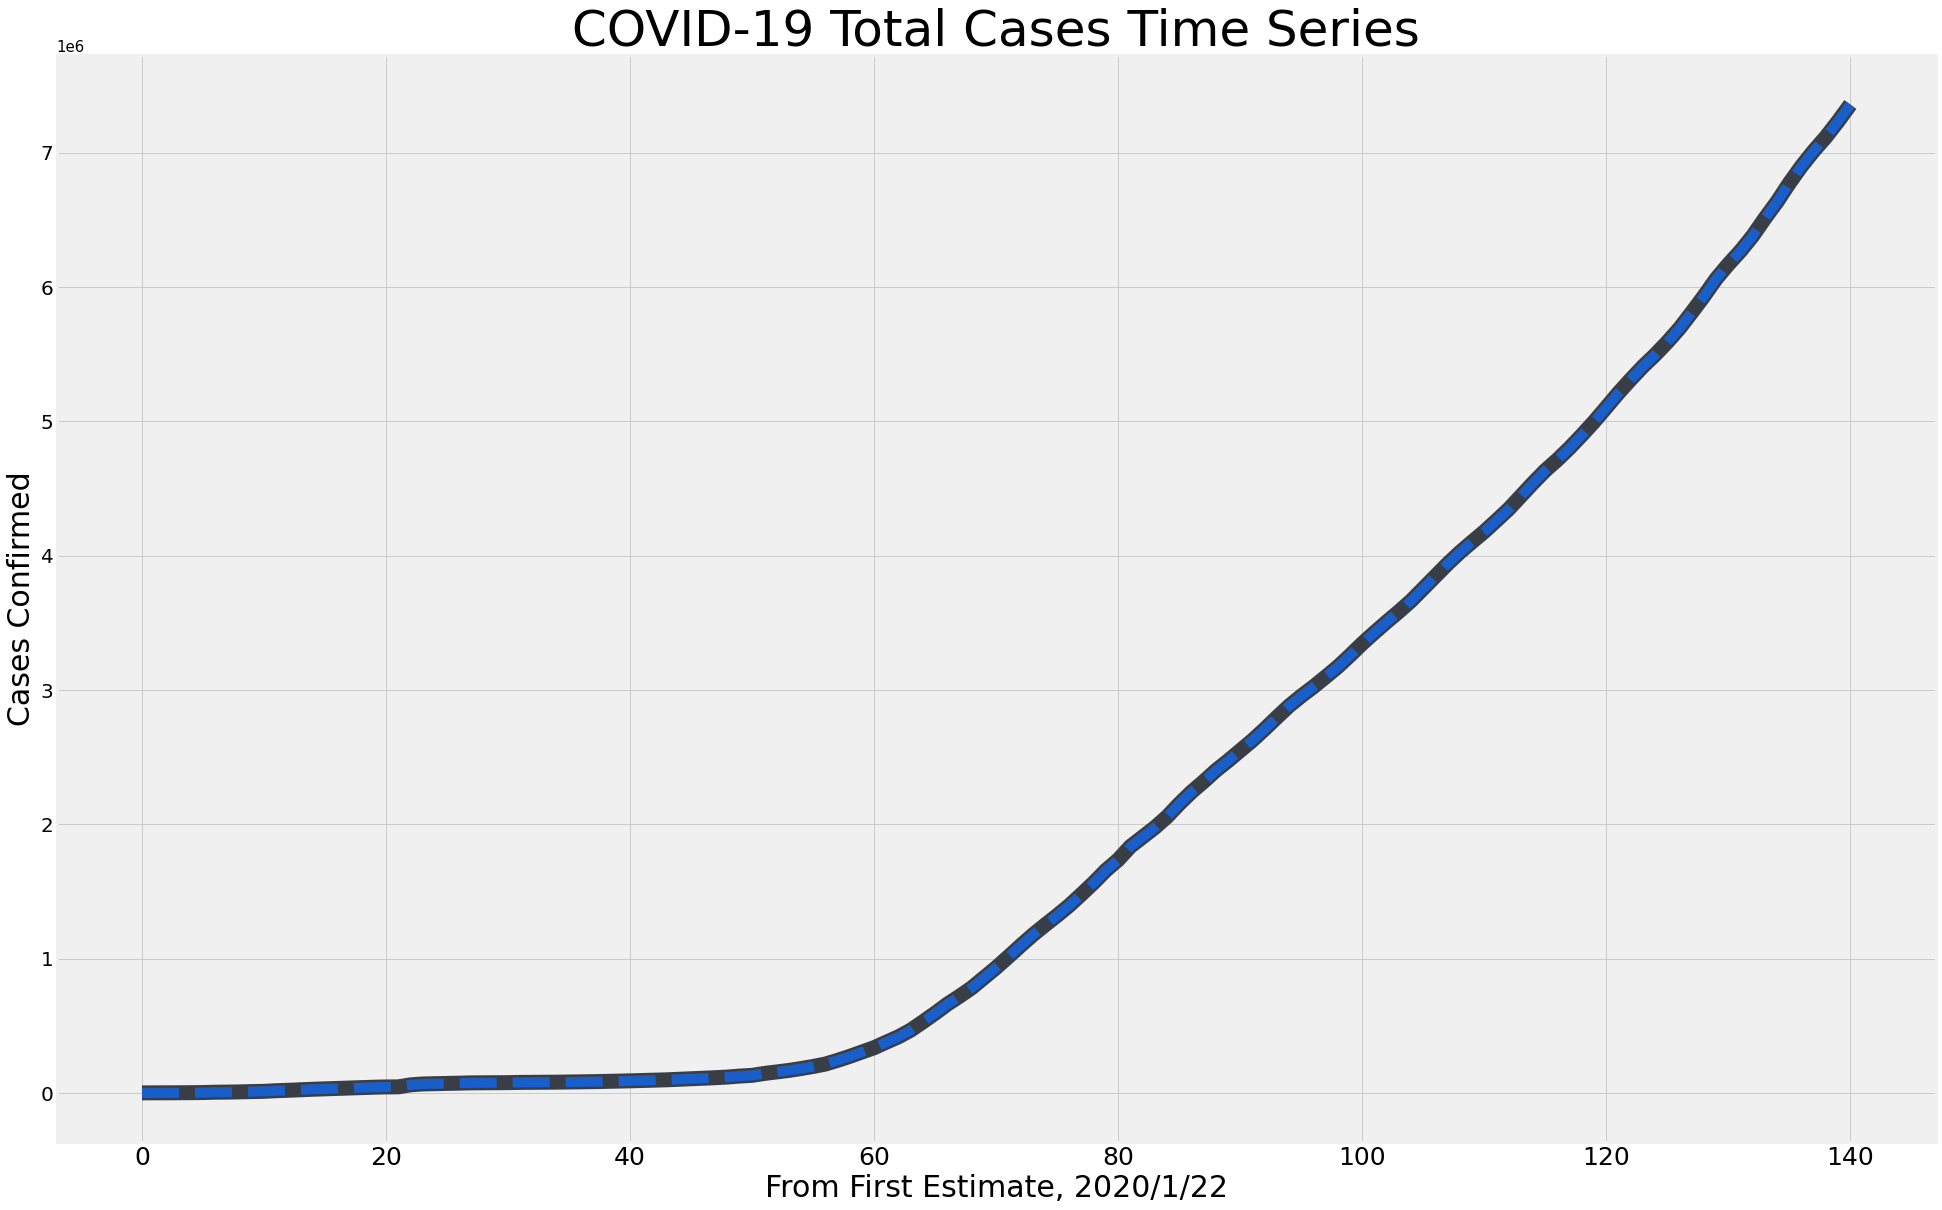

In [46]:
plt.figure(figsize=(30, 20))
plt.plot(previous_num, total_cases, linestyle='-',color='#393e46', linewidth=15)
plt.plot(previous_num, total_cases, linestyle='--', color='#1a5ec9', linewidth=10)
plt.title('COVID-19 Total Cases Time Series', size=50)
plt.xlabel('From First Estimate, 2020/1/22', size=30)
plt.ylabel('Cases Confirmed', size=30)
plt.xticks(size=25)
plt.yticks(size=20)
plt.show()

- <font color = "#CC5D9D">전세계 날짜의 흐름에 따른 누적 사망자 수<font>

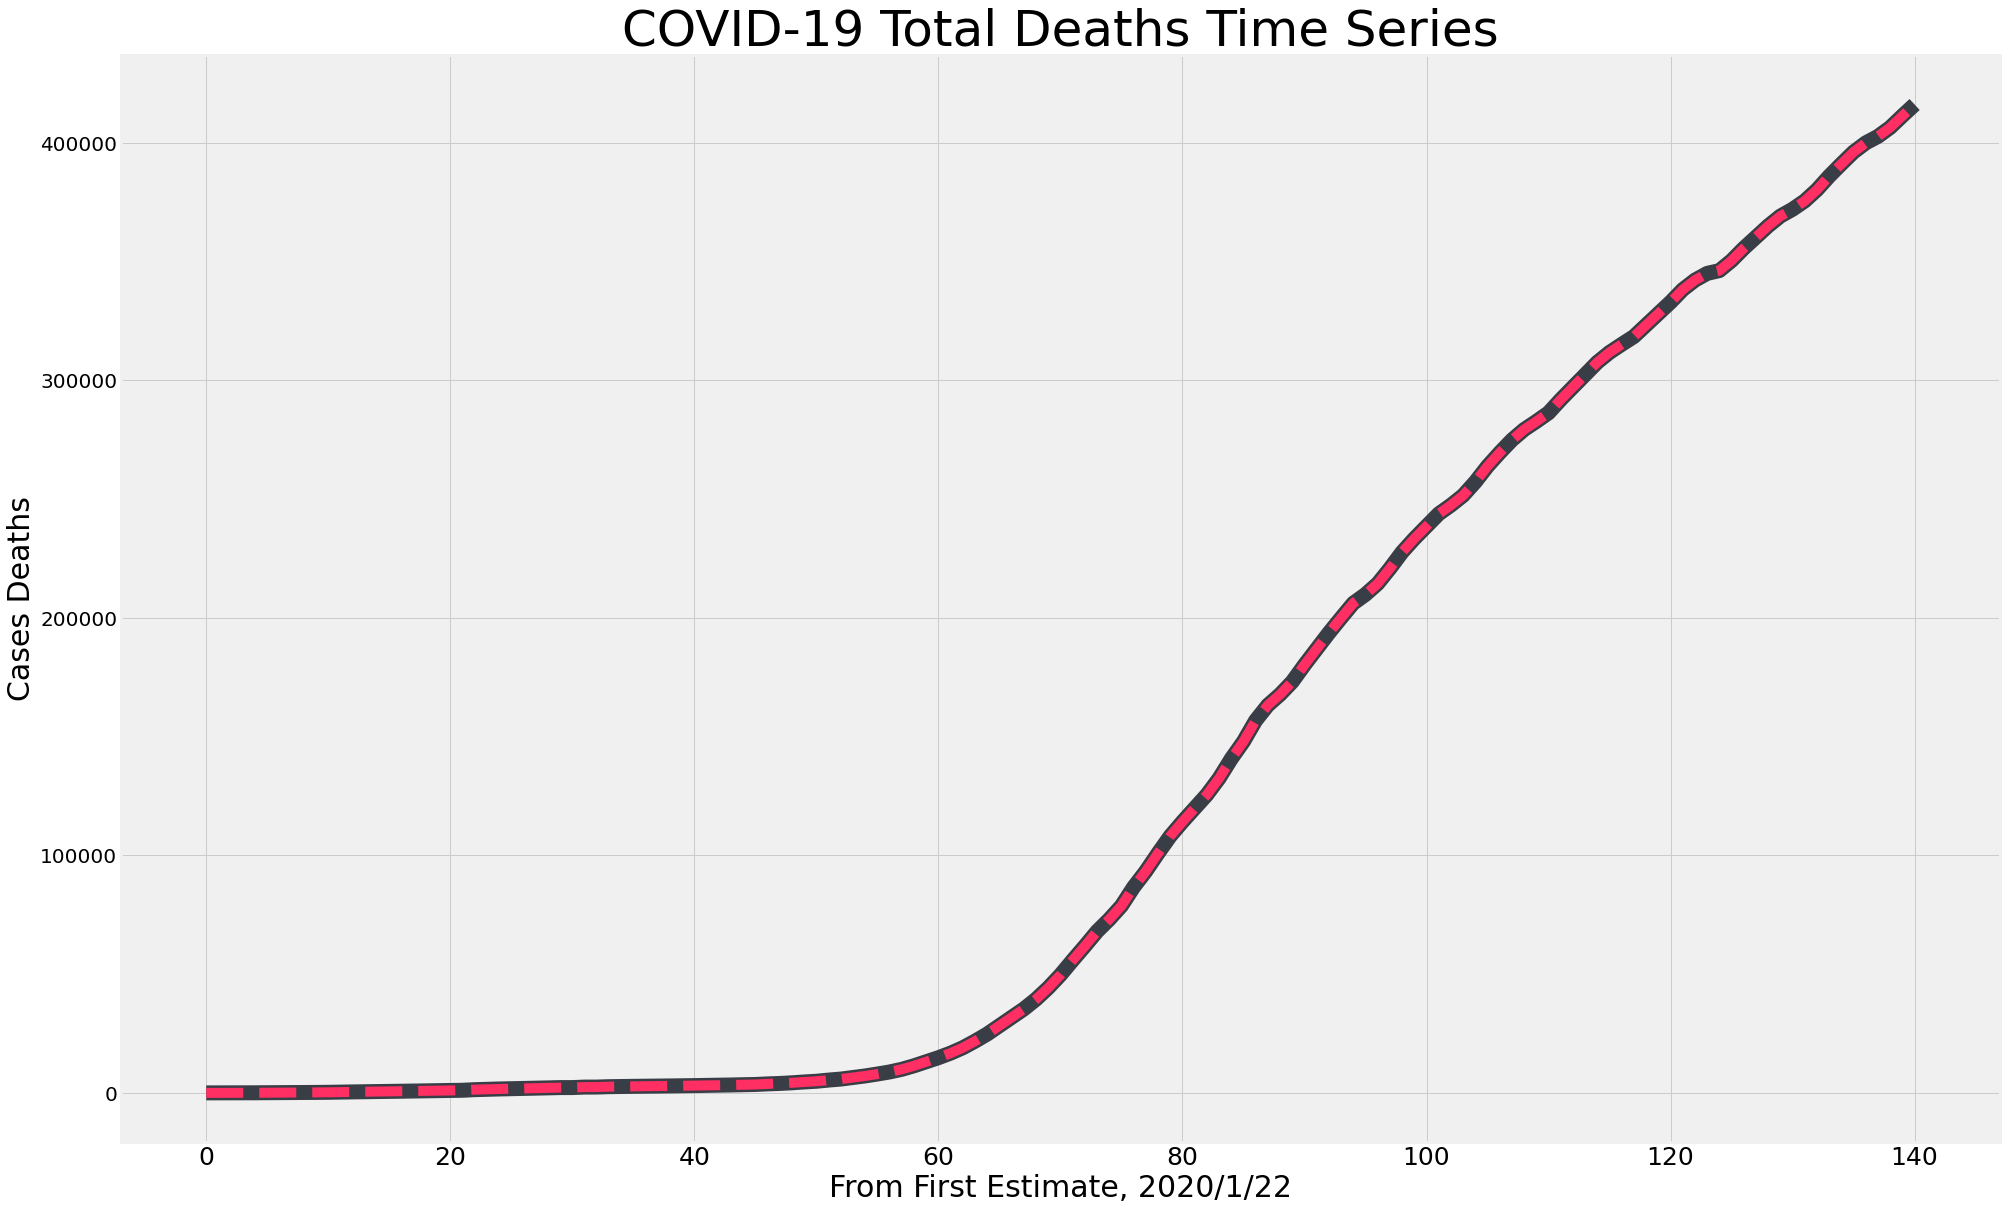

In [47]:
plt.figure(figsize=(30, 20))
plt.plot(first_estimate_day, total_deaths, linestyle='-', color='#393e46', linewidth=15)
plt.plot(first_estimate_day, total_deaths, linestyle='--', color='#ff2e63', linewidth=10)
plt.title('COVID-19 Total Deaths Time Series', size=50)
plt.xlabel('From First Estimate, 2020/1/22', size=30)
plt.ylabel('Cases Deaths', size=30)
plt.xticks(size=25)
plt.yticks(size=20)
plt.show()

- <font color = "#CC5D9D">전세계 날짜의 흐름에 따른 누적 회복인원 수<font>

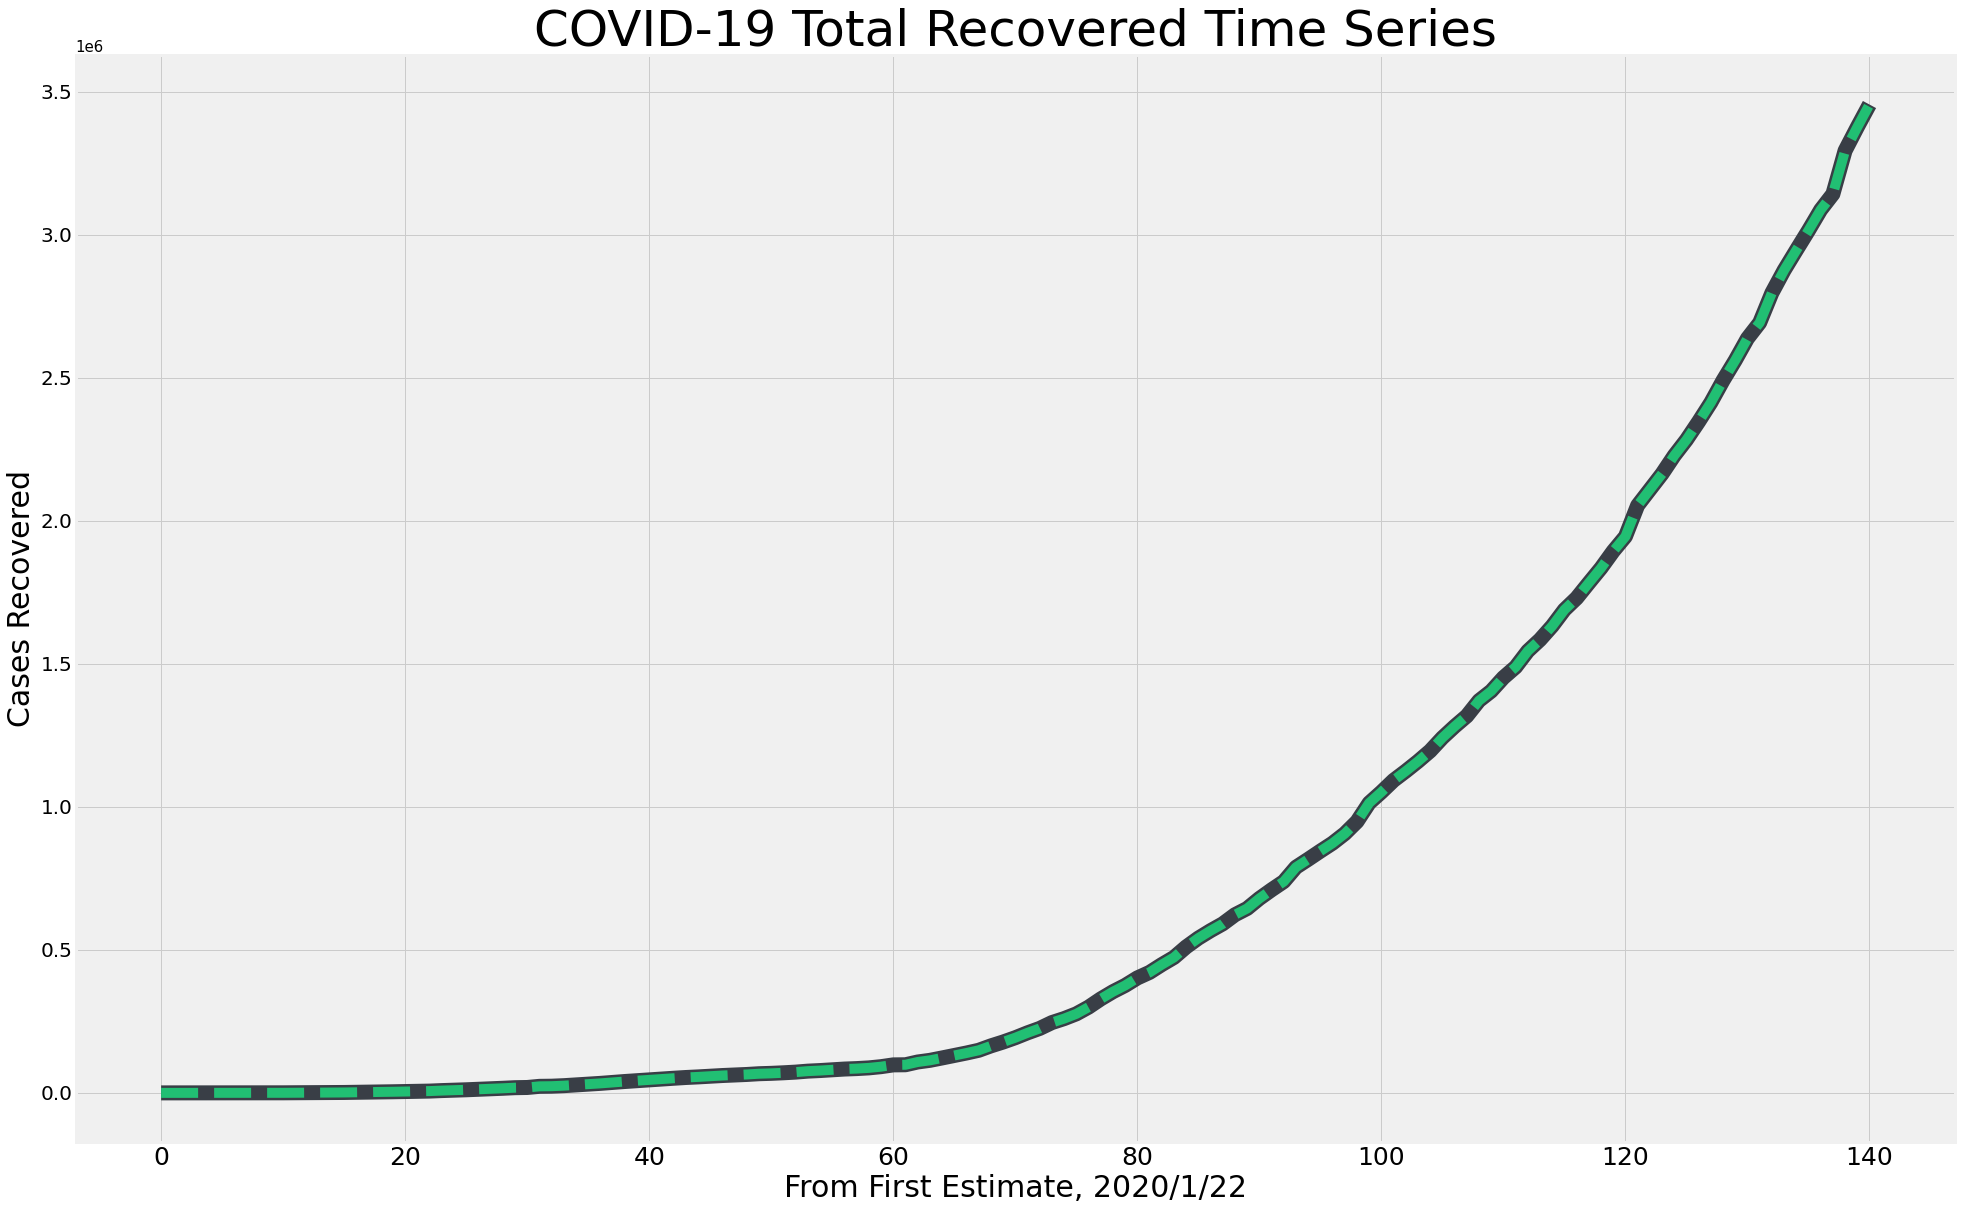

In [48]:
plt.figure(figsize=(30, 20))
plt.plot(first_estimate_day, total_recovered, linestyle='-', color='#393e46', linewidth=15)
plt.plot(first_estimate_day, total_recovered, linestyle='--', color='#21bf73', linewidth=10)
plt.title('COVID-19 Total Recovered Time Series', size=50)
plt.xlabel('From First Estimate, 2020/1/22', size=30)
plt.ylabel('Cases Recovered', size=30)
plt.xticks(size=25)
plt.yticks(size=20)
plt.show()

- <font color = "#CC5D9D">전세계 날짜의 흐름에 따른 누적 유효한인원 수(사망하거나, 회복된인원 제외)<font>

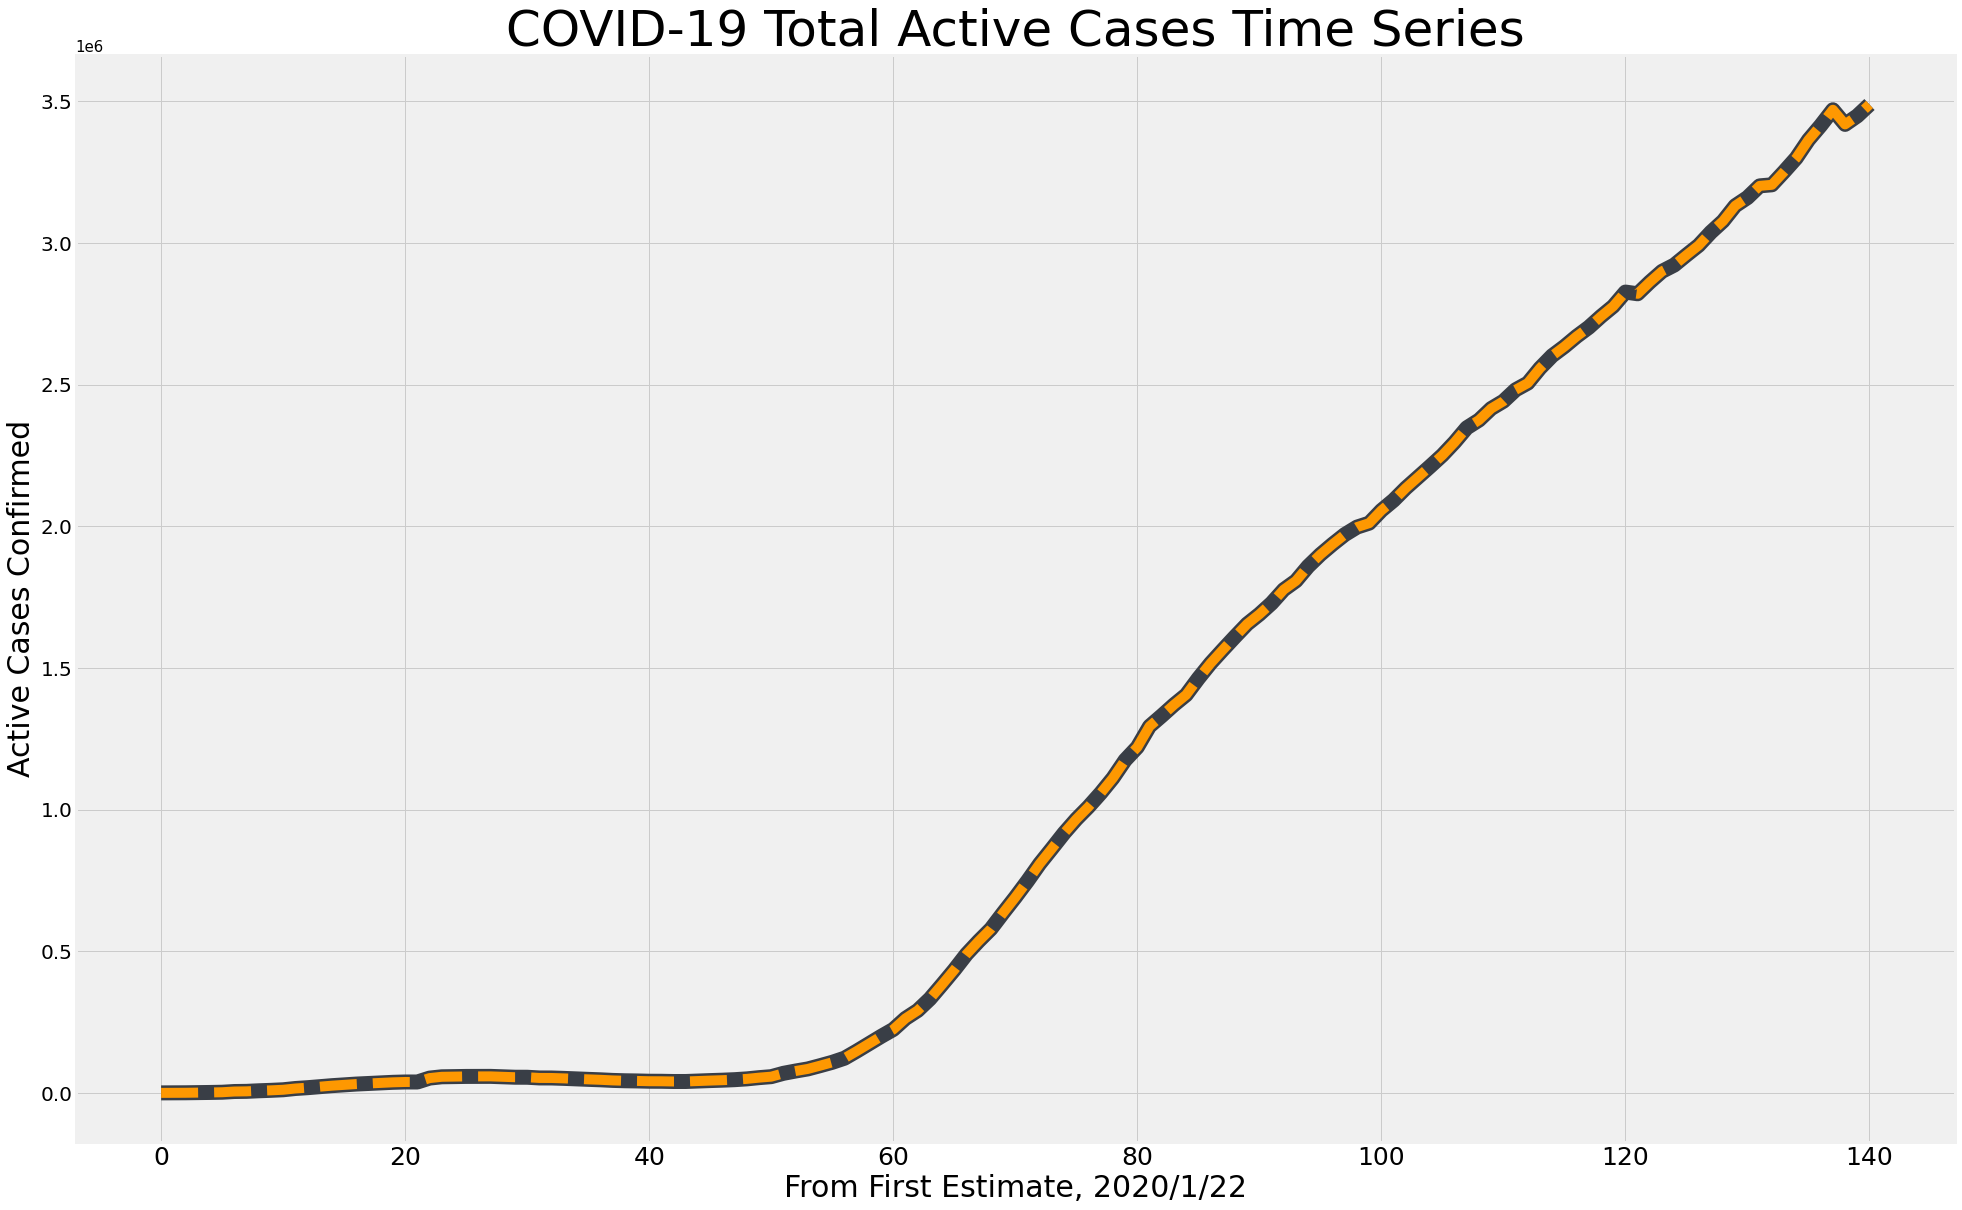

In [49]:
plt.figure(figsize=(30, 20))
plt.plot(first_estimate_day, total_active, linestyle='-', color='#393e46', linewidth=15)
plt.plot(first_estimate_day, total_active, linestyle='--', color='#fe9801', linewidth=10)
plt.title('COVID-19 Total Active Cases Time Series', size=50)
plt.xlabel('From First Estimate, 2020/1/22', size=30)
plt.ylabel('Active Cases Confirmed', size=30)
plt.xticks(size=25)
plt.yticks(size=20)
plt.show()

# 전세계 코로나 현황 분포도를 세계지도에 표현하기

In [50]:
display(cases_df.head(1))
display(deaths_df.head(1))
display(recoveries_df.head(1))

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20
0,NaN,Afghanistan,33.0,65.0,0,0,0,0,0,0,...,15750,16509,17267,18054,18969,19551,20342,20917,21459,22142


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20
0,NaN,Afghanistan,33.0,65.0,0,0,0,0,0,0,...,265,270,294,300,309,327,357,369,384,405


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20
0,NaN,Afghanistan,33.0,65.0,0,0,0,0,0,0,...,1428,1450,1522,1585,1762,1830,1875,2171,2651,3013


In [51]:
dates = cases_df.iloc[:,4:].columns
dates

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '6/1/20', '6/2/20', '6/3/20', '6/4/20', '6/5/20', '6/6/20', '6/7/20',
       '6/8/20', '6/9/20', '6/10/20'],
      dtype='object', length=141)

In [52]:
cases_mt = cases_df.melt(id_vars=['Province/State','Country/Region','Lat','Long'],
                        value_vars=dates, var_name='Date', value_name='Cases')
cases_mt

,Province/State,Country/Region,Lat,Long,Date,Cases
0,NaN,Afghanistan,33.000000,65.000000,1/22/20,0
1,NaN,Albania,41.153300,20.168300,1/22/20,0
2,NaN,Algeria,28.033900,1.659600,1/22/20,0
3,NaN,Andorra,42.506300,1.521800,1/22/20,0
4,NaN,Angola,-11.202700,17.873900,1/22/20,0
...,...,...,...,...,...,...
37501,NaN,Sao Tome and Principe,0.186360,6.613081,6/10/20,611
37502,NaN,Yemen,15.552727,48.516388,6/10/20,560
37503,NaN,Comoros,-11.645500,43.333300,6/10/20,162
37504,NaN,Tajikistan,38.861034,71.276093,6/10/20,4763


In [53]:
deaths_mt = deaths_df.melt(id_vars=['Province/State','Country/Region','Lat','Long'],
                        value_vars=dates, var_name='Date', value_name='Deaths')
deaths_mt

,Province/State,Country/Region,Lat,Long,Date,Deaths
0,NaN,Afghanistan,33.000000,65.000000,1/22/20,0
1,NaN,Albania,41.153300,20.168300,1/22/20,0
2,NaN,Algeria,28.033900,1.659600,1/22/20,0
3,NaN,Andorra,42.506300,1.521800,1/22/20,0
4,NaN,Angola,-11.202700,17.873900,1/22/20,0
...,...,...,...,...,...,...
37501,NaN,Sao Tome and Principe,0.186360,6.613081,6/10/20,12
37502,NaN,Yemen,15.552727,48.516388,6/10/20,129
37503,NaN,Comoros,-11.645500,43.333300,6/10/20,2
37504,NaN,Tajikistan,38.861034,71.276093,6/10/20,48


In [54]:
recoveries_mt = recoveries_df.melt(id_vars=['Province/State','Country/Region','Lat','Long'],
                        value_vars=dates, var_name='Date', value_name='Recovered')
recoveries_mt

,Province/State,Country/Region,Lat,Long,Date,Recovered
0,NaN,Afghanistan,33.000000,65.000000,1/22/20,0
1,NaN,Albania,41.153300,20.168300,1/22/20,0
2,NaN,Algeria,28.033900,1.659600,1/22/20,0
3,NaN,Andorra,42.506300,1.521800,1/22/20,0
4,NaN,Angola,-11.202700,17.873900,1/22/20,0
...,...,...,...,...,...,...
35668,NaN,Sao Tome and Principe,0.186360,6.613081,6/10/20,135
35669,NaN,Yemen,15.552727,48.516388,6/10/20,23
35670,NaN,Comoros,-11.645500,43.333300,6/10/20,97
35671,NaN,Tajikistan,38.861034,71.276093,6/10/20,2947


In [55]:
transformed = pd.merge(left=cases_mt, right=deaths_mt, how='left',
                      on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long'])
transformed

,Province/State,Country/Region,Lat,Long,Date,Cases,Deaths
0,NaN,Afghanistan,33.000000,65.000000,1/22/20,0,0.0
1,NaN,Albania,41.153300,20.168300,1/22/20,0,0.0
2,NaN,Algeria,28.033900,1.659600,1/22/20,0,0.0
3,NaN,Andorra,42.506300,1.521800,1/22/20,0,0.0
4,NaN,Angola,-11.202700,17.873900,1/22/20,0,0.0
...,...,...,...,...,...,...,...
37501,NaN,Sao Tome and Principe,0.186360,6.613081,6/10/20,611,12.0
37502,NaN,Yemen,15.552727,48.516388,6/10/20,560,NaN
37503,NaN,Comoros,-11.645500,43.333300,6/10/20,162,2.0
37504,NaN,Tajikistan,38.861034,71.276093,6/10/20,4763,NaN


In [56]:
transformed = pd.merge(left=transformed, right=recoveries_mt, how='left',
                      on=['Province/State','Country/Region','Lat','Long','Date'])
transformed

,Province/State,Country/Region,Lat,Long,Date,Cases,Deaths,Recovered
0,NaN,Afghanistan,33.000000,65.000000,1/22/20,0,0.0,0.0
1,NaN,Albania,41.153300,20.168300,1/22/20,0,0.0,0.0
2,NaN,Algeria,28.033900,1.659600,1/22/20,0,0.0,0.0
3,NaN,Andorra,42.506300,1.521800,1/22/20,0,0.0,0.0
4,NaN,Angola,-11.202700,17.873900,1/22/20,0,0.0,0.0
...,...,...,...,...,...,...,...,...
37501,NaN,Sao Tome and Principe,0.186360,6.613081,6/10/20,611,12.0,135.0
37502,NaN,Yemen,15.552727,48.516388,6/10/20,560,NaN,NaN
37503,NaN,Comoros,-11.645500,43.333300,6/10/20,162,2.0,97.0
37504,NaN,Tajikistan,38.861034,71.276093,6/10/20,4763,NaN,NaN


In [57]:
transformed.isna().sum()

Province/State    26085
Country/Region        0
Lat                   0
Long                  0
Date                  0
Cases                 0
Deaths             1692
Recovered          3948
dtype: int64

In [58]:
transformed[transformed['Recovered'].isna()]['Country/Region'].value_counts()

Canada         1974
China           564
Syria           141
Czechia         141
Laos            141
Timor-Leste     141
Tajikistan      141
Yemen           141
Cameroon        141
Mozambique      141
South Sudan     141
Grenada         141
Name: Country/Region, dtype: int64

In [59]:
isna = transformed[transformed['Recovered'].isna()]['Date'].value_counts()
print(isna)
print(isna.unique())

4/25/20    28
2/21/20    28
6/3/20     28
2/9/20     28
3/12/20    28
           ..
4/27/20    28
2/24/20    28
6/9/20     28
1/30/20    28
6/5/20     28
Name: Date, Length: 141, dtype: int64
[28]


In [60]:
transformed[['Cases','Deaths','Recovered']] = transformed[['Cases','Deaths','Recovered']].fillna(0).astype(int)
transformed.isna().sum()

Province/State    26085
Country/Region        0
Lat                   0
Long                  0
Date                  0
Cases                 0
Deaths                0
Recovered             0
dtype: int64

In [61]:
transformed.to_csv('transformed.csv', index=False)

In [62]:
# importing datasets
# ==================

In [63]:
transformed = pd.read_csv('transformed.csv', parse_dates=['Date'])
transformed

,Province/State,Country/Region,Lat,Long,Date,Cases,Deaths,Recovered
0,NaN,Afghanistan,33.000000,65.000000,2020-01-22,0,0,0
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,0,0
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,0,0
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,0,0
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,0,0
...,...,...,...,...,...,...,...,...
37501,NaN,Sao Tome and Principe,0.186360,6.613081,2020-06-10,611,12,135
37502,NaN,Yemen,15.552727,48.516388,2020-06-10,560,0,0
37503,NaN,Comoros,-11.645500,43.333300,2020-06-10,162,2,97
37504,NaN,Tajikistan,38.861034,71.276093,2020-06-10,4763,0,0


In [64]:
transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37506 entries, 0 to 37505
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  11421 non-null  object        
 1   Country/Region  37506 non-null  object        
 2   Lat             37506 non-null  float64       
 3   Long            37506 non-null  float64       
 4   Date            37506 non-null  datetime64[ns]
 5   Cases           37506 non-null  int64         
 6   Deaths          37506 non-null  int64         
 7   Recovered       37506 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 2.3+ MB


In [65]:
transformed.isna().sum()

Province/State    26085
Country/Region        0
Lat                   0
Long                  0
Date                  0
Cases                 0
Deaths                0
Recovered             0
dtype: int64

In [66]:
transformed[['Province/State']] = transformed[['Province/State']].fillna('')
transformed.isna().sum()

Province/State    0
Country/Region    0
Lat               0
Long              0
Date              0
Cases             0
Deaths            0
Recovered         0
dtype: int64

In [67]:
transformed['Active'] = transformed['Cases'] - transformed['Deaths'] - transformed['Recovered']
transformed

,Province/State,Country/Region,Lat,Long,Date,Cases,Deaths,Recovered,Active
0,,Afghanistan,33.000000,65.000000,2020-01-22,0,0,0,0
1,,Albania,41.153300,20.168300,2020-01-22,0,0,0,0
2,,Algeria,28.033900,1.659600,2020-01-22,0,0,0,0
3,,Andorra,42.506300,1.521800,2020-01-22,0,0,0,0
4,,Angola,-11.202700,17.873900,2020-01-22,0,0,0,0
...,...,...,...,...,...,...,...,...,...
37501,,Sao Tome and Principe,0.186360,6.613081,2020-06-10,611,12,135,464
37502,,Yemen,15.552727,48.516388,2020-06-10,560,0,0,560
37503,,Comoros,-11.645500,43.333300,2020-06-10,162,2,97,63
37504,,Tajikistan,38.861034,71.276093,2020-06-10,4763,0,0,4763


In [68]:
full_grouped = transformed.sort_values(['Country/Region','Date'])
full_grouped

,Province/State,Country/Region,Lat,Long,Date,Cases,Deaths,Recovered,Active
0,,Afghanistan,33.0,65.0,2020-01-22,0,0,0,0
266,,Afghanistan,33.0,65.0,2020-01-23,0,0,0,0
532,,Afghanistan,33.0,65.0,2020-01-24,0,0,0,0
798,,Afghanistan,33.0,65.0,2020-01-25,0,0,0,0
1064,,Afghanistan,33.0,65.0,2020-01-26,0,0,0,0
...,...,...,...,...,...,...,...,...,...
36406,,Zimbabwe,-20.0,30.0,2020-06-06,279,4,33,242
36672,,Zimbabwe,-20.0,30.0,2020-06-07,282,4,34,244
36938,,Zimbabwe,-20.0,30.0,2020-06-08,287,4,46,237
37204,,Zimbabwe,-20.0,30.0,2020-06-09,314,4,46,264


## 신규 확진,사망,완치 데이터 셋팅

In [69]:
new_confirmed = full_grouped.groupby(['Province/State','Country/Region','Lat','Long','Date'])['Cases','Deaths','Recovered']
new_confirmed = new_confirmed.sum().diff().reset_index()
new_confirmed

,Province/State,Country/Region,Lat,Long,Date,Cases,Deaths,Recovered
0,,Afghanistan,33.0000,65.0000,2020-01-22,NaN,NaN,NaN
1,,Afghanistan,33.0000,65.0000,2020-01-23,0.0,0.0,0.0
2,,Afghanistan,33.0000,65.0000,2020-01-24,0.0,0.0,0.0
3,,Afghanistan,33.0000,65.0000,2020-01-25,0.0,0.0,0.0
4,,Afghanistan,33.0000,65.0000,2020-01-26,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
37501,Zhejiang,China,29.1832,120.0934,2020-06-06,0.0,0.0,0.0
37502,Zhejiang,China,29.1832,120.0934,2020-06-07,0.0,0.0,0.0
37503,Zhejiang,China,29.1832,120.0934,2020-06-08,0.0,0.0,0.0
37504,Zhejiang,China,29.1832,120.0934,2020-06-09,0.0,0.0,0.0


In [70]:
mask = new_confirmed['Country/Region'] != new_confirmed['Country/Region'].shift(1)
mask

0         True
1        False
2        False
3        False
4        False
         ...  
37501    False
37502    False
37503    False
37504    False
37505    False
Name: Country/Region, Length: 37506, dtype: bool

In [71]:
import numpy as np
new_confirmed.loc[mask, 'Cases'] = np.nan
new_confirmed.loc[mask, 'Deaths'] = np.nan
new_confirmed.loc[mask, 'Recovered'] = np.nan

In [72]:
new_confirmed.columns = ['Province/State','Country/Region','Lat','Long','Date','New Cases','New Deaths','New Recovered']
new_confirmed

,Province/State,Country/Region,Lat,Long,Date,New Cases,New Deaths,New Recovered
0,,Afghanistan,33.0000,65.0000,2020-01-22,NaN,NaN,NaN
1,,Afghanistan,33.0000,65.0000,2020-01-23,0.0,0.0,0.0
2,,Afghanistan,33.0000,65.0000,2020-01-24,0.0,0.0,0.0
3,,Afghanistan,33.0000,65.0000,2020-01-25,0.0,0.0,0.0
4,,Afghanistan,33.0000,65.0000,2020-01-26,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
37501,Zhejiang,China,29.1832,120.0934,2020-06-06,0.0,0.0,0.0
37502,Zhejiang,China,29.1832,120.0934,2020-06-07,0.0,0.0,0.0
37503,Zhejiang,China,29.1832,120.0934,2020-06-08,0.0,0.0,0.0
37504,Zhejiang,China,29.1832,120.0934,2020-06-09,0.0,0.0,0.0


In [73]:
full_grouped = pd.merge(full_grouped, new_confirmed, how='left', on=['Province/State','Country/Region','Lat','Long','Date'])
full_grouped

,Province/State,Country/Region,Lat,Long,Date,Cases,Deaths,Recovered,Active,New Cases,New Deaths,New Recovered
0,,Afghanistan,33.0,65.0,2020-01-22,0,0,0,0,NaN,NaN,NaN
1,,Afghanistan,33.0,65.0,2020-01-23,0,0,0,0,0.0,0.0,0.0
2,,Afghanistan,33.0,65.0,2020-01-24,0,0,0,0,0.0,0.0,0.0
3,,Afghanistan,33.0,65.0,2020-01-25,0,0,0,0,0.0,0.0,0.0
4,,Afghanistan,33.0,65.0,2020-01-26,0,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
37501,,Zimbabwe,-20.0,30.0,2020-06-06,279,4,33,242,14.0,0.0,0.0
37502,,Zimbabwe,-20.0,30.0,2020-06-07,282,4,34,244,3.0,0.0,1.0
37503,,Zimbabwe,-20.0,30.0,2020-06-08,287,4,46,237,5.0,0.0,12.0
37504,,Zimbabwe,-20.0,30.0,2020-06-09,314,4,46,264,27.0,0.0,0.0


In [74]:
full_grouped.isna().sum()

Province/State      0
Country/Region      0
Lat                 0
Long                0
Date                0
Cases               0
Deaths              0
Recovered           0
Active              0
New Cases         235
New Deaths        235
New Recovered     235
dtype: int64

In [75]:
full_grouped[['New Cases','New Deaths','New Recovered']] = full_grouped[['New Cases','New Deaths','New Recovered']].fillna(0).astype(int)
full_grouped.isna().sum()

Province/State    0
Country/Region    0
Lat               0
Long              0
Date              0
Cases             0
Deaths            0
Recovered         0
Active            0
New Cases         0
New Deaths        0
New Recovered     0
dtype: int64

In [76]:
w_map = full_grouped[full_grouped['Date'] == max(full_grouped['Date'])]
w_map

,Province/State,Country/Region,Lat,Long,Date,Cases,Deaths,Recovered,Active,New Cases,New Deaths,New Recovered
140,,Afghanistan,33.000000,65.000000,2020-06-10,22142,405,3013,18724,683,21,362
281,,Albania,41.153300,20.168300,2020-06-10,1341,34,980,327,42,0,20
422,,Algeria,28.033900,1.659600,2020-06-10,10484,732,7074,2678,102,8,123
563,,Andorra,42.506300,1.521800,2020-06-10,852,51,759,42,0,0,2
704,,Angola,-11.202700,17.873900,2020-06-10,113,4,40,69,17,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
36941,,West Bank and Gaza,31.952200,35.233200,2020-06-10,485,3,410,72,4,0,6
37082,,Western Sahara,24.215500,-12.885800,2020-06-10,9,1,6,2,0,0,0
37223,,Yemen,15.552727,48.516388,2020-06-10,560,0,0,560,36,0,0
37364,,Zambia,-15.416700,28.283300,2020-06-10,1200,10,912,278,0,0,0


In [77]:
# World wide
import calmap
import folium

m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=4, zoom_start=2)

for i in range(0, len(w_map)):
    folium.Circle(
        location=[w_map.iloc[i]['Lat'], w_map.iloc[i]['Long']],
        color='crimson', fill='crimson',
        tooltip =   '<li><bold>Country : '+str(w_map.iloc[i]['Country/Region'])+
                    '<li><bold>Province : '+str(w_map.iloc[i]['Province/State'])+
                    '<li><bold>Cases : '+str(w_map.iloc[i]['Cases'])+
                    '<li><bold>Deaths : '+str(w_map.iloc[i]['Deaths'])+
                    '<li><bold>Recoveries : '+str(w_map.iloc[i]['Recovered'])+
                    '<li><bold>New Cases : '+str(w_map.iloc[i]['New Cases'])+
                    '<li><bold>New Deaths : '+str(w_map.iloc[i]['New Deaths'])+
                    '<li><bold>New Recoveries : '+str(w_map.iloc[i]['New Recovered'])+
                    '<li><bold><font color = "#CC5D9D">### Active : '+str(w_map.iloc[i]['Active']),
        radius=int(w_map.iloc[i]['Cases'])**1.0).add_to(m)
m

In [78]:
full_grouped[['New Cases','New Deaths','New Recovered']] = full_grouped[['New Cases','New Deaths','New Recovered']].apply(lambda x: 0 if x<0 else x)
full_grouped

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# Day wise
# table
day_wise = full_grouped.groupby('Date')['Cases','Deaths','Recovered','Active','New Cases','New Deaths','New Recovered'].sum().reset_index()
day_wise

In [ ]:
import plotly.express as px
import plotly.express as px

In [ ]:
fig = px.line_3d(w_map, x="Date", y="Cases", z="New cases")
fig.show()

In [ ]:
import plotly.graph_objects as go

import pandas as pd

# Read data from a csv
z_data = cases_df

fig = go.Figure(data=[go.Surface(z=z_data.values)])

fig.update_layout(title='World Cases Confirmed Time Series', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [ ]:
import plotly.graph_objects as go

import pandas as pd

# Read data from a csv
z_data = cases_df

fig = go.Figure(data=[go.Surface(z=z_data.values)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='World Cases Confirmed Time Series', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

In [ ]:
fig = go.Figure(data=go.Scattergeo(lon=cases_df['Long'], lat=cases_df['Lat'], mode='markers'))
fig.update_layout(title='Cases confirmed', geo_scope='world')

fig.show()

In [ ]:
cases_df

In [ ]:
cases_df.iloc[:,4:]

In [ ]:
import plotly.express as px
df = cases_df
fig = px.line(df, x=cases_df.columns[4:], y=cases_df.iloc[0,4:],
        line_shape="spline", render_mode="svg")
fig.show()

df = deaths_df
fig = px.line(df, x=deaths_df.columns[4:], y=deaths_df.iloc[0,4:],
        line_shape="spline", render_mode="svg")
fig.show()

df = recoveries_df
fig = px.line(df, x=recoveries_df.columns[4:], y=recoveries_df.iloc[0,4:],
        line_shape="spline", render_mode="svg")
fig.show()